In [1]:
import os
import logging
import dill as pickle
import urllib
import random
from tqdm import tqdm
import sys
import codecs
import spacy
import time

import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tarfile
import torchtext.data
import torchtext.datasets

import argparse

In [2]:
device = torch.device("cuda", index=2)
output_dir = './output_lambda=15.0'
lambda_ = 15.0

In [3]:
_TRAIN_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/" \
             "training-parallel-nc-v12.tgz",
     "trg": "news-commentary-v12.de-en.en",
     "src": "news-commentary-v12.de-en.de"}
    ]

_VAL_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/dev.tgz",
     "trg": "newstest2013.en",
     "src": "newstest2013.de"}]

_TEST_DATA_SOURCES = [
    {"url": "https://storage.googleapis.com/tf-perf-public/" \
                "official_transformer/test_data/newstest2014.tgz",
     "trg": "newstest2014.en",
     "src": "newstest2014.de"}]

In [4]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def file_exist(dir_name, file_name):
    for sub_dir, _, files in os.walk(dir_name):
        if file_name in files:
            return os.path.join(sub_dir, file_name)
    return None

In [5]:
def download_and_extract(download_dir, url, src_filename, trg_filename):
    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        sys.stderr.write(f"Already downloaded and extracted {url}.\n")
        return src_path, trg_path

    compressed_file = _download_file(download_dir, url)

    sys.stderr.write(f"Extracting {compressed_file}.\n")
    with tarfile.open(compressed_file, "r:gz") as corpus_tar:
        corpus_tar.extractall(download_dir)

    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        return src_path, trg_path

    raise OSError(f"Download/extraction failed for url {url} to path {download_dir}")

def _download_file(download_dir, url):
    filename = url.split("/")[-1]
    if file_exist(download_dir, filename):
        sys.stderr.write(f"Already downloaded: {url} (at {filename}).\n")
    else:
        sys.stderr.write(f"Downloading from {url} to {filename}.\n")
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, filename=filename, reporthook=t.update_to)
    return filename

def get_raw_files(raw_dir, sources):
    raw_files = { "src": [], "trg": [], }
    for d in sources:
        src_file, trg_file = download_and_extract(raw_dir, d["url"], d["src"], d["trg"])
        raw_files["src"].append(src_file)
        raw_files["trg"].append(trg_file)
    return raw_files

In [6]:
def mkdir_if_needed(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)

In [7]:
def compile_files(raw_dir, raw_files, prefix):
    src_fpath = os.path.join(raw_dir, f"raw-{prefix}.src")
    trg_fpath = os.path.join(raw_dir, f"raw-{prefix}.trg")

    if os.path.isfile(src_fpath) and os.path.isfile(trg_fpath):
        sys.stderr.write(f"Merged files found, skip the merging process.\n")
        return src_fpath, trg_fpath

    sys.stderr.write(f"Merge files into two files: {src_fpath} and {trg_fpath}.\n")

    with open(src_fpath, 'w') as src_outf, open(trg_fpath, 'w') as trg_outf:
        for src_inf, trg_inf in zip(raw_files['src'], raw_files['trg']):
            sys.stderr.write(f'  Input files: \n'\
                    f'    - SRC: {src_inf}, and\n' \
                    f'    - TRG: {trg_inf}.\n')
            with open(src_inf, newline='\n') as src_inf, open(trg_inf, newline='\n') as trg_inf:
                cntr = 0
                for i, line in enumerate(src_inf):
                    cntr += 1
                    src_outf.write(line.replace('\r', ' ').strip() + '\n')
                for j, line in enumerate(trg_inf):
                    cntr -= 1
                    trg_outf.write(line.replace('\r', ' ').strip() + '\n')
                assert cntr == 0, 'Number of lines in two files are inconsistent.'
    return src_fpath, trg_fpath

In [8]:
def encode_file(bpe, in_file, out_file):
    sys.stderr.write(f"Read raw content from {in_file} and \n"\
            f"Write encoded content to {out_file}\n")
    
    with codecs.open(in_file, encoding='utf-8') as in_f:
        with codecs.open(out_file, 'w', encoding='utf-8') as out_f:
            for line in in_f:
                out_f.write(bpe.process_line(line))

def encode_files(bpe, src_in_file, trg_in_file, data_dir, prefix):
    src_out_file = os.path.join(data_dir, f"{prefix}.src")
    trg_out_file = os.path.join(data_dir, f"{prefix}.trg")

    if os.path.isfile(src_out_file) and os.path.isfile(trg_out_file):
        sys.stderr.write(f"Encoded files found, skip the encoding process ...\n")

    encode_file(bpe, src_in_file, src_out_file)
    encode_file(bpe, trg_in_file, trg_out_file)
    return src_out_file, trg_out_file

In [9]:
src_lang_model = spacy.load('de_core_news_sm')
trg_lang_model = spacy.load('en_core_web_sm')

In [10]:
PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [11]:
def tokenize_src(text):
        return [tok.text for tok in src_lang_model.tokenizer(text)]

def tokenize_trg(text):
    return [tok.text for tok in trg_lang_model.tokenizer(text)]

SRC = torchtext.legacy.data.Field(
    tokenize=tokenize_src, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

TRG = torchtext.legacy.data.Field(
    tokenize=tokenize_trg, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

In [12]:
MAX_LEN = 100
MIN_FREQ = 3

In [13]:
def filter_examples_with_length(x):
    return len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN

In [14]:
ROOT = '../Datasets/Multi30k/'
train, val, test = torchtext.legacy.datasets.Multi30k.splits(
            root=ROOT,
            exts = ('.' + 'de', '.' + 'en'),
            fields = (SRC, TRG),
            filter_pred=filter_examples_with_length)

In [15]:
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
print('[Info] Get source language vocabulary size:', len(SRC.vocab))
TRG.build_vocab(train.trg, min_freq=MIN_FREQ)
print('[Info] Get target language vocabulary size:', len(TRG.vocab))

[Info] Get source language vocabulary size: 5374
[Info] Get target language vocabulary size: 4556


In [16]:
print('[Info] Merging two vocabulary ...')
for w, _ in SRC.vocab.stoi.items():
    if w not in TRG.vocab.stoi:
        TRG.vocab.stoi[w] = len(TRG.vocab.stoi)
TRG.vocab.itos = [None] * len(TRG.vocab.stoi)
for w, i in TRG.vocab.stoi.items():
    TRG.vocab.itos[i] = w
SRC.vocab.stoi = TRG.vocab.stoi
SRC.vocab.itos = TRG.vocab.itos
print('[Info] Get merged vocabulary size:', len(TRG.vocab))

[Info] Merging two vocabulary ...
[Info] Get merged vocabulary size: 9521


In [17]:
spacy_support_langs = ['de', 'el', 'en', 'es', 'fr', 'it', 'lt', 'nb', 'nl', 'pt']

parser = argparse.ArgumentParser()
parser.add_argument('-lang_src', required=True, choices=spacy_support_langs)
parser.add_argument('-lang_trg', required=True, choices=spacy_support_langs)
parser.add_argument('-save_data', required=True)
parser.add_argument('-data_src', type=str, default=None)
parser.add_argument('-data_trg', type=str, default=None)

parser.add_argument('-max_len', type=int, default=100)
parser.add_argument('-min_word_count', type=int, default=3)
parser.add_argument('-keep_case', action='store_true')
parser.add_argument('-share_vocab', action='store_true')

opt = parser.parse_args(args=['-lang_src', 'de', '-lang_trg', 'en', '-share_vocab', '-save_data', './m30k_deen_shr.pkl'])

In [18]:
data = {
    'settings': opt,
    'vocab': {'src': SRC, 'trg': TRG},
    'train': train.examples,
    'valid': val.examples,
    'test': test.examples}

print('[Info] Dumping the processed data to pickle file', opt.save_data)
pickle.dump(data, open(opt.save_data, 'wb'))

[Info] Dumping the processed data to pickle file ./m30k_deen_shr.pkl


# 学習設定

In [19]:
parser = argparse.ArgumentParser()

parser.add_argument('-data_pkl', default=None)     # all-in-1 data pickle or bpe field
parser.add_argument('-train_path', default=None)   # bpe encoded data
parser.add_argument('-val_path', default=None)     # bpe encoded data
parser.add_argument('-epoch', type=int, default=10)
parser.add_argument('-b', '--batch_size', type=int, default=2048)
parser.add_argument('-d_model', type=int, default=512)
parser.add_argument('-d_inner_hid', type=int, default=2048)
parser.add_argument('-d_k', type=int, default=64)
parser.add_argument('-d_v', type=int, default=64)
parser.add_argument('-n_head', type=int, default=8)
parser.add_argument('-n_layers', type=int, default=6)
parser.add_argument('-warmup','--n_warmup_steps', type=int, default=4000)
parser.add_argument('-lr_mul', type=float, default=2.0)
parser.add_argument('-seed', type=int, default=None)
parser.add_argument('-dropout', type=float, default=0.1)
parser.add_argument('-embs_share_weight', action='store_true')
parser.add_argument('-proj_share_weight', action='store_true')
parser.add_argument('-scale_emb_or_prj', type=str, default='prj')
parser.add_argument('-output_dir', type=str, default=None)
parser.add_argument('-use_tb', action='store_true')
parser.add_argument('-save_mode', type=str, choices=['all', 'best'], default='best')
parser.add_argument('-no_cuda', action='store_true')
parser.add_argument('-label_smoothing', action='store_true')

opt = parser.parse_args(
    args=['-data_pkl', './m30k_deen_shr.pkl', '-seed', '428', '-embs_share_weight', '-proj_share_weight', '-label_smoothing', '-output_dir', output_dir, '-b', '512', '-warmup', '128000', '-epoch', '1000'])
opt.cuda = not opt.no_cuda
opt.d_word_vec = opt.d_model

In [20]:
if opt.seed is not None:
    torch.manual_seed(opt.seed)
    torch.backends.cudnn.benchmark = False
    np.random.seed(opt.seed)
    random.seed(opt.seed)

In [21]:
if opt.batch_size < 2048 and opt.n_warmup_steps <= 4000:
    print('[Warning] The warmup steps may be not enough.\n'\
            '(sz_b, warmup) = (2048, 4000) is the official setting.\n'\
            'Using smaller batch w/o longer warmup may cause '\
            'the warmup stage ends with only little data trained.')

In [22]:
def prepare_dataloaders(opt, device):
    batch_size = opt.batch_size
    data = pickle.load(open(opt.data_pkl, 'rb'))

    opt.max_token_seq_len = data['settings'].max_len
    opt.src_pad_idx = data['vocab']['src'].vocab.stoi[PAD_WORD]
    opt.trg_pad_idx = data['vocab']['trg'].vocab.stoi[PAD_WORD]

    opt.src_vocab_size = len(data['vocab']['src'].vocab)
    opt.trg_vocab_size = len(data['vocab']['trg'].vocab)

    if opt.embs_share_weight:
        assert data['vocab']['src'].vocab.stoi == data['vocab']['trg'].vocab.stoi, \
            'To sharing word embedding the src/trg word2idx table shall be the same.'

    fields = {'src': data['vocab']['src'], 'trg':data['vocab']['trg']}

    train = torchtext.legacy.data.Dataset(examples=data['train'], fields=fields)
    val = torchtext.legacy.data.Dataset(examples=data['valid'], fields=fields)

    train_iterator = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size, device=device, train=True)
    val_iterator = torchtext.legacy.data.BucketIterator(val, batch_size=batch_size, device=device)

    return train_iterator, val_iterator

In [23]:
training_data, validation_data = prepare_dataloaders(opt, device)

# Gate 付き Transformer の実装と実体化

In [24]:
class BinaryGate(nn.Module):
    
    def __init__(self, num_gates: int, init: float=0.0):
        super(BinaryGate, self).__init__()
        
        self.num_gates = num_gates
        self.gate = nn.parameter.Parameter(torch.zeros(num_gates).fill_(init))
    
    def forward(self, beta=0.667, gamma=-0.1, zeta = 1.0, 
                hard = True, eps = 1e-6, threshold=0.5):
        
        loss_constant = (beta * math.log(-gamma / zeta)) if (gamma < 0) else 0.0
        
        if self.training:
            noise = torch.zeros(self.num_gates)
            noise = noise.cuda(self.gate.device)
            
            noise.data.uniform_(eps, 1 - eps)
            u = noise.data
            
            s = torch.log(u) - torch.log(1.0 - u)
            
            s = (s + self.gate) / beta
            s = torch.sigmoid(s)
        else:
            s = torch.sigmoid(self.gate)
        
        s = s * (zeta - gamma) + gamma
        out = torch.clamp(s, eps, 1)
        
        if hard:
            out_hard = torch.greater_equal(out, threshold).float()
            out = out + (out_hard - out).detach()
            sparsity = torch.eq(out, 0).sum()
        else:
            sparsity = torch.less(out, threshold).float().sum()
        
        l0_loss = torch.sigmoid(self.gate - loss_constant)
        l0_loss = torch.clamp(l0_loss, eps, 1.0 - eps).sum()
        
        return out, l0_loss, (sparsity.detach().cpu(), self.num_gates)

In [25]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

In [26]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.gate = BinaryGate(num_gates=n_head, init=2.0)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        
        bin_mask, l0_loss, sparsity = self.gate()
        bin_mask = torch.cat([bin_mask[i].repeat(self.d_model//self.n_head) for i in range(self.n_head)])
        
        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)
        
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q *= bin_mask
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn, l0_loss, sparsity


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [27]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn, l0_loss, sparsity = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        
        return enc_output, enc_slf_attn, l0_loss, sparsity


class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn, l0_loss1, sparsity1 = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn, l0_loss2, sparsity2 = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        
        return dec_output, dec_slf_attn, dec_enc_attn, l0_loss1+l0_loss2, sparsity1, sparsity2

In [28]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []
        l0_loss = 0.0
        sparsity = [0, 0]
        
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn, l0, spa = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            l0_loss += l0
            sparsity[0] += spa[0]
            sparsity[1] += spa[1]

        if return_attns:
            return enc_output, l0_loss, sparsity, enc_slf_attn_list
        return enc_output, l0_loss, sparsity,


class Decoder(nn.Module):

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []
        l0_loss = 0.0
        sparsity1 = [0, 0]
        sparsity2 = [0, 0]
        
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn, l0, spa1, spa2 = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
            l0_loss += l0
            sparsity1[0] += spa1[0]
            sparsity1[1] += spa1[1]
            sparsity2[0] += spa2[0]
            sparsity2[1] += spa2[1]

        if return_attns:
            return dec_output, l0_loss, sparsity1, sparsity2, dec_slf_attn_list, dec_enc_attn_list
        return dec_output, l0_loss, sparsity1, sparsity2,

In [29]:
class Transformer(nn.Module):

    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):

        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, l0_loss1, sparsity1, *_ = self.encoder(src_seq, src_mask)
        dec_output, l0_loss2, sparsity2, sparsity3, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        return seq_logit.view(-1, seq_logit.size(2)), l0_loss1+l0_loss2, (sparsity1, sparsity2, sparsity3)

In [30]:
transformer = Transformer(
        opt.src_vocab_size,
        opt.trg_vocab_size,
        src_pad_idx=opt.src_pad_idx,
        trg_pad_idx=opt.trg_pad_idx,
        trg_emb_prj_weight_sharing=opt.proj_share_weight,
        emb_src_trg_weight_sharing=opt.embs_share_weight,
        d_k=opt.d_k,
        d_v=opt.d_v,
        d_model=opt.d_model,
        d_word_vec=opt.d_word_vec,
        d_inner=opt.d_inner_hid,
        n_layers=opt.n_layers,
        n_head=opt.n_head,
        dropout=opt.dropout,
        scale_emb_or_prj=opt.scale_emb_or_prj).to(device)

# Optimizer の実装と実体化

In [31]:
class ScheduledOptim():

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [32]:
optimizer = ScheduledOptim(
        optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        opt.lr_mul, opt.d_model, opt.n_warmup_steps)

# 訓練と検証

In [33]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word


def cal_loss(pred, gold, trg_pad_idx, smoothing=False):

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss


def patch_src(src, pad_idx):
    src = src.transpose(0, 1)
    return src


def patch_trg(trg, pad_idx):
    trg = trg.transpose(0, 1)
    trg, gold = trg[:, :-1], trg[:, 1:].contiguous().view(-1)
    return trg, gold


def train_epoch(model, training_data, optimizer, opt, device, smoothing, lambda_):

    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 
    enc_sparsity = [0, 0]
    dec_sparsity1 = [0, 0]
    dec_sparsity2 = [0, 0]
    
    desc = '  - (Training)   '
    for batch in tqdm(training_data, mininterval=2, desc=desc, leave=False):
        
        src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
        trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

        # forward
        optimizer.zero_grad()
        pred, l0_loss, sparsity = model(src_seq, trg_seq)

        # backward and update parameters
        loss, n_correct, n_word = cal_performance(
            pred, gold, opt.trg_pad_idx, smoothing=smoothing)
        loss_ = loss + lambda_ * l0_loss
        loss_.backward()
        optimizer.step_and_update_lr()

        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()
        enc_sparsity[0] += sparsity[0][0]
        enc_sparsity[1] += sparsity[0][1]
        dec_sparsity1[0] += sparsity[1][0]
        dec_sparsity1[1] += sparsity[1][1]
        dec_sparsity2[0] += sparsity[2][0]
        dec_sparsity2[1] += sparsity[2][1]
        

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy, (enc_sparsity, dec_sparsity1, dec_sparsity2)


def eval_epoch(model, validation_data, device, opt, lambda_):

    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0

    desc = '  - (Validation) '
    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):

            # prepare data
            src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
            trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

            # forward
            pred, l0_loss, sparsity = model(src_seq, trg_seq)
            loss, n_correct, n_word = cal_performance(
                pred, gold, opt.trg_pad_idx, smoothing=False)
            
            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

In [34]:
def train(model, training_data, validation_data, optimizer, device, opt, lambda_=0.0):
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')
    log_sparsity_file = os.path.join(opt.output_dir, 'sparsity.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file, log_sparsity_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf, open(log_sparsity_file, 'w') as log_sf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')
        log_sf.write('epoch,enc-sa,dec-sa, dec-enc\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu, sparsity = train_epoch(
            model, training_data, optimizer, opt, device, smoothing=opt.label_smoothing, lambda_=lambda_)
        train_ppl = math.exp(min(train_loss, 100))
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt, lambda_=lambda_)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf, open(log_sparsity_file, 'a') as log_sf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))
            log_sf.write('{epoch},{enc: 3.3f},{dec1: 3.3f},{dec2: 3.3f}\n'.format(
                epoch=epoch_i, 
                enc =(sparsity[0][1]-sparsity[0][0])/sparsity[0][1],
                dec1=(sparsity[1][1]-sparsity[1][0])/sparsity[1][1],
                dec2=(sparsity[2][1]-sparsity[2][0])/sparsity[2][1]))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)

In [35]:
train(transformer, training_data, validation_data, optimizer, device, opt, lambda_=lambda_)

[Info] Training performance will be written to file: ./output_lambda=15.0/train.log and ./output_lambda=15.0/valid.log
[ Epoch 0 ]


  - (Training)   ppl:  9500.33826, accuracy: 0.006 %, lr:  0.00000, elapse: 0.306 min


  - (Validation) ppl:  9474.57718, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   ppl:  9484.22100, accuracy: 0.012 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9435.46182, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


  - (Training)   ppl:  9453.71184, accuracy: 0.848 %, lr:  0.00000, elapse: 0.305 min


  - (Validation) ppl:  9377.63548, accuracy: 11.981 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


  - (Training)   ppl:  9412.59618, accuracy: 6.186 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  9315.28115, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]


  - (Training)   ppl:  9361.59024, accuracy: 11.625 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  9256.47094, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]


  - (Training)   ppl:  9316.18397, accuracy: 11.957 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  9202.75087, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]


  - (Training)   ppl:  9271.09247, accuracy: 12.014 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9155.00722, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   ppl:  9233.23838, accuracy: 12.015 %, lr:  0.00000, elapse: 0.307 min


  - (Validation) ppl:  9114.49368, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]


  - (Training)   ppl:  9198.37593, accuracy: 12.015 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  9078.45125, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]


  - (Training)   ppl:  9164.51258, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  9043.89195, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 10 ]


  - (Training)   ppl:  9132.23386, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  9012.63556, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 11 ]


  - (Training)   ppl:  9102.60194, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8982.85033, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]


  - (Training)   ppl:  9071.91020, accuracy: 12.015 %, lr:  0.00000, elapse: 0.330 min


  - (Validation) ppl:  8953.86836, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 13 ]


  - (Training)   ppl:  9044.64769, accuracy: 12.015 %, lr:  0.00000, elapse: 0.323 min


  - (Validation) ppl:  8925.93602, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 14 ]


  - (Training)   ppl:  9017.21016, accuracy: 12.015 %, lr:  0.00000, elapse: 0.321 min


  - (Validation) ppl:  8897.96566, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 15 ]


  - (Training)   ppl:  8988.09261, accuracy: 12.015 %, lr:  0.00000, elapse: 0.327 min


  - (Validation) ppl:  8869.34393, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 16 ]


  - (Training)   ppl:  8962.55160, accuracy: 12.015 %, lr:  0.00000, elapse: 0.320 min


  - (Validation) ppl:  8840.30248, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 17 ]


  - (Training)   ppl:  8932.18473, accuracy: 12.015 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8809.66630, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 18 ]


  - (Training)   ppl:  8902.71441, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8777.21759, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 19 ]


  - (Training)   ppl:  8870.90454, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8742.37173, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 20 ]


  - (Training)   ppl:  8839.28486, accuracy: 12.015 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8704.39530, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 21 ]


  - (Training)   ppl:  8802.45385, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8661.31277, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 22 ]


  - (Training)   ppl:  8761.00429, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8614.55089, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 23 ]


  - (Training)   ppl:  8719.33846, accuracy: 12.016 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8565.97192, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 24 ]


  - (Training)   ppl:  8674.97289, accuracy: 12.155 %, lr:  0.00000, elapse: 0.321 min


  - (Validation) ppl:  8517.09319, accuracy: 13.830 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 25 ]


  - (Training)   ppl:  8628.36262, accuracy: 13.382 %, lr:  0.00000, elapse: 0.326 min


  - (Validation) ppl:  8463.40460, accuracy: 16.309 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 26 ]


  - (Training)   ppl:  8581.32308, accuracy: 15.122 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  8407.20428, accuracy: 16.454 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 27 ]


  - (Training)   ppl:  8534.72517, accuracy: 15.923 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8361.96586, accuracy: 16.205 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 28 ]


  - (Training)   ppl:  8488.04783, accuracy: 16.330 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8302.38649, accuracy: 17.168 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 29 ]


  - (Training)   ppl:  8439.32357, accuracy: 16.594 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8249.79022, accuracy: 17.639 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 30 ]


  - (Training)   ppl:  8391.87769, accuracy: 16.761 %, lr:  0.00000, elapse: 0.308 min


  - (Validation) ppl:  8197.12356, accuracy: 17.431 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 31 ]


  - (Training)   ppl:  8343.38306, accuracy: 16.920 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  8140.36570, accuracy: 17.749 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 32 ]


  - (Training)   ppl:  8293.54206, accuracy: 16.970 %, lr:  0.00000, elapse: 0.319 min


  - (Validation) ppl:  8090.44369, accuracy: 17.742 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 33 ]


  - (Training)   ppl:  8242.90125, accuracy: 17.074 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8029.70952, accuracy: 17.701 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 34 ]


  - (Training)   ppl:  8191.61541, accuracy: 16.933 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  7969.77406, accuracy: 18.172 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 35 ]


  - (Training)   ppl:  8136.84409, accuracy: 17.067 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  7912.78144, accuracy: 17.791 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 36 ]


  - (Training)   ppl:  8081.85138, accuracy: 17.116 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  7846.98468, accuracy: 17.832 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 37 ]


  - (Training)   ppl:  8026.68253, accuracy: 17.038 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  7784.78800, accuracy: 17.888 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 38 ]


  - (Training)   ppl:  7969.53260, accuracy: 17.089 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  7722.84823, accuracy: 18.352 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 39 ]


  - (Training)   ppl:  7910.71354, accuracy: 17.082 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  7657.86015, accuracy: 17.562 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 40 ]


  - (Training)   ppl:  7850.79977, accuracy: 16.972 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  7589.43701, accuracy: 18.199 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 41 ]


  - (Training)   ppl:  7790.49265, accuracy: 16.989 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  7521.61913, accuracy: 17.950 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 42 ]


  - (Training)   ppl:  7728.71660, accuracy: 16.863 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  7453.52407, accuracy: 17.819 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 43 ]


  - (Training)   ppl:  7665.35011, accuracy: 16.893 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  7384.60504, accuracy: 18.082 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 44 ]


  - (Training)   ppl:  7600.98451, accuracy: 16.832 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  7316.71911, accuracy: 18.532 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 45 ]


  - (Training)   ppl:  7536.13335, accuracy: 16.643 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  7242.41839, accuracy: 18.109 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 46 ]


  - (Training)   ppl:  7469.25050, accuracy: 16.541 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  7167.05336, accuracy: 17.015 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 47 ]


  - (Training)   ppl:  7401.79285, accuracy: 16.474 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  7093.96159, accuracy: 16.343 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 48 ]


  - (Training)   ppl:  7334.31077, accuracy: 16.442 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  7017.92935, accuracy: 17.271 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 49 ]


  - (Training)   ppl:  7264.71202, accuracy: 16.527 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  6941.85565, accuracy: 17.562 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 50 ]


  - (Training)   ppl:  7194.30749, accuracy: 16.250 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6864.89787, accuracy: 17.611 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 51 ]


  - (Training)   ppl:  7124.29594, accuracy: 16.154 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6788.03666, accuracy: 17.521 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 52 ]


  - (Training)   ppl:  7051.98582, accuracy: 15.975 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6711.13911, accuracy: 17.902 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 53 ]


  - (Training)   ppl:  6978.70087, accuracy: 15.938 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6631.00901, accuracy: 17.036 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 54 ]


  - (Training)   ppl:  6906.42091, accuracy: 15.818 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6551.44042, accuracy: 17.382 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 55 ]


  - (Training)   ppl:  6833.05837, accuracy: 15.811 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6471.03734, accuracy: 16.503 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 56 ]


  - (Training)   ppl:  6758.57057, accuracy: 15.649 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  6390.68912, accuracy: 16.011 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 57 ]


  - (Training)   ppl:  6684.11663, accuracy: 15.370 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6312.28449, accuracy: 13.864 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 58 ]


  - (Training)   ppl:  6608.87062, accuracy: 15.046 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  6228.56731, accuracy: 16.371 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 59 ]


  - (Training)   ppl:  6531.89302, accuracy: 15.001 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  6146.57396, accuracy: 16.191 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 60 ]


  - (Training)   ppl:  6455.44714, accuracy: 14.854 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6063.28120, accuracy: 15.637 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 61 ]


  - (Training)   ppl:  6377.93805, accuracy: 14.721 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  5981.27409, accuracy: 15.706 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 62 ]


  - (Training)   ppl:  6302.15211, accuracy: 14.420 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5898.54725, accuracy: 15.644 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 63 ]


  - (Training)   ppl:  6223.65727, accuracy: 14.302 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  5814.96492, accuracy: 13.934 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 64 ]


  - (Training)   ppl:  6145.52372, accuracy: 14.156 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  5732.46460, accuracy: 13.961 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 65 ]


  - (Training)   ppl:  6067.25950, accuracy: 13.941 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5648.66642, accuracy: 13.726 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 66 ]


  - (Training)   ppl:  5989.33402, accuracy: 13.728 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  5566.14290, accuracy: 13.193 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 67 ]


  - (Training)   ppl:  5911.26808, accuracy: 13.456 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5482.25133, accuracy: 13.310 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 68 ]


  - (Training)   ppl:  5831.98877, accuracy: 13.325 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  5398.55065, accuracy: 12.853 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 69 ]


  - (Training)   ppl:  5753.17855, accuracy: 13.135 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5316.41695, accuracy: 12.722 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 70 ]


  - (Training)   ppl:  5673.67467, accuracy: 12.965 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5231.80788, accuracy: 12.209 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 71 ]


  - (Training)   ppl:  5595.08112, accuracy: 12.783 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  5148.68323, accuracy: 12.798 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 72 ]


  - (Training)   ppl:  5517.10604, accuracy: 12.656 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5066.79568, accuracy: 12.078 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 73 ]


  - (Training)   ppl:  5436.93838, accuracy: 12.538 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4984.96972, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 74 ]


  - (Training)   ppl:  5358.87335, accuracy: 12.489 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4900.79418, accuracy: 12.036 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 75 ]


  - (Training)   ppl:  5279.61651, accuracy: 12.372 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  4818.43235, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 76 ]


  - (Training)   ppl:  5201.44934, accuracy: 12.314 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4736.71270, accuracy: 12.015 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 77 ]


  - (Training)   ppl:  5122.46473, accuracy: 12.242 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4656.12079, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 78 ]


  - (Training)   ppl:  5044.23551, accuracy: 12.165 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  4574.32924, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 79 ]


  - (Training)   ppl:  4966.57933, accuracy: 12.155 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4493.44689, accuracy: 12.008 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 80 ]


  - (Training)   ppl:  4888.97125, accuracy: 12.083 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4412.44508, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 81 ]


  - (Training)   ppl:  4811.66613, accuracy: 12.103 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  4334.18946, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 82 ]


  - (Training)   ppl:  4734.04589, accuracy: 12.057 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  4254.00159, accuracy: 12.001 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 83 ]


  - (Training)   ppl:  4657.23665, accuracy: 12.057 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4175.29391, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 84 ]


  - (Training)   ppl:  4581.25061, accuracy: 12.044 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  4096.41318, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 85 ]


  - (Training)   ppl:  4505.29055, accuracy: 12.033 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4019.45542, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 86 ]


  - (Training)   ppl:  4429.97413, accuracy: 12.023 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3942.92362, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 87 ]


  - (Training)   ppl:  4354.89884, accuracy: 12.020 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3865.99224, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 88 ]


  - (Training)   ppl:  4280.39429, accuracy: 12.024 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3790.21224, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 89 ]


  - (Training)   ppl:  4206.33378, accuracy: 12.020 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3715.39297, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 90 ]


  - (Training)   ppl:  4133.17374, accuracy: 12.018 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3640.75923, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 91 ]


  - (Training)   ppl:  4060.38044, accuracy: 12.017 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3568.90274, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 92 ]


  - (Training)   ppl:  3987.69503, accuracy: 12.016 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3496.00187, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 93 ]


  - (Training)   ppl:  3916.09409, accuracy: 12.016 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  3423.72033, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 94 ]


  - (Training)   ppl:  3845.08203, accuracy: 12.016 %, lr:  0.00001, elapse: 0.308 min


  - (Validation) ppl:  3352.70560, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 95 ]


  - (Training)   ppl:  3774.72050, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  3282.31223, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 96 ]


  - (Training)   ppl:  3704.79735, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3213.16127, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 97 ]


  - (Training)   ppl:  3635.68993, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3144.51515, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 98 ]


  - (Training)   ppl:  3567.11495, accuracy: 12.015 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  3077.20074, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 99 ]


  - (Training)   ppl:  3499.51635, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3009.68226, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 100 ]


  - (Training)   ppl:  3432.36802, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2945.60319, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 101 ]


  - (Training)   ppl:  3366.67078, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2879.60395, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 102 ]


  - (Training)   ppl:  3300.98214, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2815.22589, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 103 ]


  - (Training)   ppl:  3236.47337, accuracy: 12.015 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  2752.71823, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 104 ]


  - (Training)   ppl:  3172.88654, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2690.74960, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 105 ]


  - (Training)   ppl:  3109.23103, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2628.58128, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 106 ]


  - (Training)   ppl:  3047.27235, accuracy: 12.015 %, lr:  0.00001, elapse: 0.326 min


  - (Validation) ppl:  2568.64204, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 107 ]


  - (Training)   ppl:  2985.85498, accuracy: 12.015 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  2508.40045, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 108 ]


  - (Training)   ppl:  2924.95685, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  2450.36235, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 109 ]


  - (Training)   ppl:  2865.23064, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  2393.05010, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 110 ]


  - (Training)   ppl:  2806.19226, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2337.01006, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 111 ]


  - (Training)   ppl:  2748.08784, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2280.99299, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 112 ]


  - (Training)   ppl:  2690.78688, accuracy: 12.015 %, lr:  0.00001, elapse: 0.326 min


  - (Validation) ppl:  2227.04506, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 113 ]


  - (Training)   ppl:  2634.57733, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2173.31807, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 114 ]


  - (Training)   ppl:  2578.70128, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2121.17011, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 115 ]


  - (Training)   ppl:  2524.10334, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2070.11605, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 116 ]


  - (Training)   ppl:  2470.26541, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2018.43895, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 117 ]


  - (Training)   ppl:  2417.32481, accuracy: 12.015 %, lr:  0.00001, elapse: 0.325 min


  - (Validation) ppl:  1969.62146, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 118 ]


  - (Training)   ppl:  2365.08371, accuracy: 12.015 %, lr:  0.00001, elapse: 0.326 min


  - (Validation) ppl:  1920.61462, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 119 ]


  - (Training)   ppl:  2313.70926, accuracy: 12.015 %, lr:  0.00001, elapse: 0.326 min


  - (Validation) ppl:  1872.42643, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 120 ]


  - (Training)   ppl:  2263.54024, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1824.72942, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 121 ]


  - (Training)   ppl:  2213.82956, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1778.87144, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 122 ]


  - (Training)   ppl:  2165.35568, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  1734.38174, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 123 ]


  - (Training)   ppl:  2117.65739, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1690.09832, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 124 ]


  - (Training)   ppl:  2070.57972, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1646.37229, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 125 ]


  - (Training)   ppl:  2024.45252, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  1604.84775, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 126 ]


  - (Training)   ppl:  1979.48001, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  1564.03964, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 127 ]


  - (Training)   ppl:  1934.97155, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1523.38335, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 128 ]


  - (Training)   ppl:  1891.70114, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1483.60849, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 129 ]


  - (Training)   ppl:  1848.82300, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1444.70134, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 130 ]


  - (Training)   ppl:  1807.10868, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1407.42736, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 131 ]


  - (Training)   ppl:  1765.97778, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1370.83210, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 132 ]


  - (Training)   ppl:  1725.94272, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  1334.54235, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 133 ]


  - (Training)   ppl:  1686.62598, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  1299.37358, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 134 ]


  - (Training)   ppl:  1648.22668, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  1264.94679, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 135 ]


  - (Training)   ppl:  1610.60986, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1231.60038, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 136 ]


  - (Training)   ppl:  1573.70685, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1199.87125, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 137 ]


  - (Training)   ppl:  1537.67084, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  1167.44203, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 138 ]


  - (Training)   ppl:  1502.30195, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1136.23871, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 139 ]


  - (Training)   ppl:  1467.69105, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  1106.19701, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 140 ]


  - (Training)   ppl:  1433.99049, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  1076.61578, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 141 ]


  - (Training)   ppl:  1401.04347, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  1047.69437, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 142 ]


  - (Training)   ppl:  1368.82352, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  1020.33430, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 143 ]


  - (Training)   ppl:  1337.18655, accuracy: 12.015 %, lr:  0.00002, elapse: 0.333 min


  - (Validation) ppl:  992.79506, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 144 ]


  - (Training)   ppl:  1306.53933, accuracy: 12.015 %, lr:  0.00002, elapse: 0.326 min


  - (Validation) ppl:  966.01846, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 145 ]


  - (Training)   ppl:  1276.24821, accuracy: 12.015 %, lr:  0.00002, elapse: 0.324 min


  - (Validation) ppl:  940.00550, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 146 ]


  - (Training)   ppl:  1246.94554, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  915.32643, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 147 ]


  - (Training)   ppl:  1218.30353, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  890.42530, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 148 ]


  - (Training)   ppl:  1190.22226, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  866.72477, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 149 ]


  - (Training)   ppl:  1162.87328, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  843.21632, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 150 ]


  - (Training)   ppl:  1136.25508, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  820.75237, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 151 ]


  - (Training)   ppl:  1110.32110, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  798.94220, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 152 ]


  - (Training)   ppl:  1084.92654, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  777.70403, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 153 ]


  - (Training)   ppl:  1060.30260, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  757.14492, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 154 ]


  - (Training)   ppl:  1036.13208, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  736.74973, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 155 ]


  - (Training)   ppl:  1012.69948, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  717.35438, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 156 ]


  - (Training)   ppl:  989.83669, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  698.26390, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 157 ]


  - (Training)   ppl:  967.52549, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  679.68844, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 158 ]


  - (Training)   ppl:  945.89726, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  661.81567, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 159 ]


  - (Training)   ppl:  924.79263, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  644.50178, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 160 ]


  - (Training)   ppl:  904.36397, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  627.68228, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 161 ]


  - (Training)   ppl:  884.33194, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  611.29576, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 162 ]


  - (Training)   ppl:  864.89970, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  595.42514, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 163 ]


  - (Training)   ppl:  846.01862, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  579.99040, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 164 ]


  - (Training)   ppl:  827.68223, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  565.08981, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 165 ]


  - (Training)   ppl:  809.91647, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  550.90277, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 166 ]


  - (Training)   ppl:  792.59958, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  536.77329, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 167 ]


  - (Training)   ppl:  775.81943, accuracy: 12.015 %, lr:  0.00002, elapse: 0.321 min


  - (Validation) ppl:  523.28060, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 168 ]


  - (Training)   ppl:  759.48301, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  510.16764, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 169 ]


  - (Training)   ppl:  743.59522, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  497.49740, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 170 ]


  - (Training)   ppl:  728.18103, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  485.17123, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 171 ]


  - (Training)   ppl:  713.30283, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  473.35401, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 172 ]


  - (Training)   ppl:  698.86547, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  461.90458, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 173 ]


  - (Training)   ppl:  684.73773, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  450.70099, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 174 ]


  - (Training)   ppl:  671.09859, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  439.98430, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 175 ]


  - (Training)   ppl:  657.91184, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  429.58238, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 176 ]


  - (Training)   ppl:  645.06462, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  419.46666, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 177 ]


  - (Training)   ppl:  632.67000, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  409.69276, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 178 ]


  - (Training)   ppl:  620.63044, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  400.31127, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 179 ]


  - (Training)   ppl:  609.02231, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  391.29287, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 180 ]


  - (Training)   ppl:  597.67041, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  382.45116, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 181 ]


  - (Training)   ppl:  586.78615, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  373.98098, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 182 ]


  - (Training)   ppl:  576.22976, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  365.76854, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 183 ]


  - (Training)   ppl:  566.06695, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  357.93624, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 184 ]


  - (Training)   ppl:  556.16762, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  350.29628, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 185 ]


  - (Training)   ppl:  546.64571, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  342.95158, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 186 ]


  - (Training)   ppl:  537.48399, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  335.83799, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 187 ]


  - (Training)   ppl:  528.60902, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  329.05920, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 188 ]


  - (Training)   ppl:  520.09058, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  322.49233, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 189 ]


  - (Training)   ppl:  511.84392, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  316.17076, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 190 ]


  - (Training)   ppl:  503.92885, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  310.07552, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 191 ]


  - (Training)   ppl:  496.34407, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  304.21757, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 192 ]


  - (Training)   ppl:  489.10419, accuracy: 12.015 %, lr:  0.00002, elapse: 0.327 min


  - (Validation) ppl:  298.65428, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 193 ]


  - (Training)   ppl:  482.08617, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  293.25483, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 194 ]


  - (Training)   ppl:  475.42765, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  288.22460, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 195 ]


  - (Training)   ppl:  469.05575, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  283.26456, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 196 ]


  - (Training)   ppl:  462.90552, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  278.52645, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 197 ]


  - (Training)   ppl:  457.00505, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  274.00112, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 198 ]


  - (Training)   ppl:  451.31657, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  269.72036, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 199 ]


  - (Training)   ppl:  445.88450, accuracy: 12.016 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  265.46677, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 200 ]


  - (Training)   ppl:  440.56532, accuracy: 12.021 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  261.56717, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 201 ]


  - (Training)   ppl:  435.22987, accuracy: 12.042 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  257.33465, accuracy: 12.105 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 202 ]


  - (Training)   ppl:  430.25982, accuracy: 12.073 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  253.59264, accuracy: 12.036 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 203 ]


  - (Training)   ppl:  425.38438, accuracy: 12.096 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  251.05321, accuracy: 12.112 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 204 ]


  - (Training)   ppl:  420.81284, accuracy: 12.142 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  246.33477, accuracy: 12.112 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 205 ]


  - (Training)   ppl:  415.87172, accuracy: 12.192 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  243.61411, accuracy: 12.050 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 206 ]


  - (Training)   ppl:  411.63242, accuracy: 12.206 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  240.06597, accuracy: 12.043 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 207 ]


  - (Training)   ppl:  407.23226, accuracy: 12.264 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  236.72321, accuracy: 12.071 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 208 ]


  - (Training)   ppl:  402.95183, accuracy: 12.286 %, lr:  0.00002, elapse: 0.321 min


  - (Validation) ppl:  233.21240, accuracy: 12.119 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 209 ]


  - (Training)   ppl:  398.55916, accuracy: 12.339 %, lr:  0.00002, elapse: 0.329 min


  - (Validation) ppl:  230.41678, accuracy: 12.084 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 210 ]


  - (Training)   ppl:  394.38288, accuracy: 12.361 %, lr:  0.00002, elapse: 0.321 min


  - (Validation) ppl:  226.85149, accuracy: 12.091 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 211 ]


  - (Training)   ppl:  390.48834, accuracy: 12.385 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  223.93243, accuracy: 12.043 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 212 ]


  - (Training)   ppl:  386.47462, accuracy: 12.389 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  221.23872, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 213 ]


  - (Training)   ppl:  382.62824, accuracy: 12.387 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  218.86336, accuracy: 12.064 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 214 ]


  - (Training)   ppl:  378.72115, accuracy: 12.384 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  216.06030, accuracy: 12.064 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 215 ]


  - (Training)   ppl:  374.94672, accuracy: 12.402 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  212.57386, accuracy: 12.029 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 216 ]


  - (Training)   ppl:  371.32715, accuracy: 12.439 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  210.77775, accuracy: 12.078 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 217 ]


  - (Training)   ppl:  367.68743, accuracy: 12.572 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  208.43226, accuracy: 12.161 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 218 ]


  - (Training)   ppl:  363.79183, accuracy: 12.514 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  205.57874, accuracy: 12.181 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 219 ]


  - (Training)   ppl:  360.13822, accuracy: 12.661 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  203.25008, accuracy: 11.994 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 220 ]


  - (Training)   ppl:  356.77801, accuracy: 12.716 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  201.37204, accuracy: 12.424 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 221 ]


  - (Training)   ppl:  352.77676, accuracy: 13.011 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  198.62625, accuracy: 12.618 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 222 ]


  - (Training)   ppl:  349.25900, accuracy: 13.246 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  195.11993, accuracy: 12.500 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 223 ]


  - (Training)   ppl:  345.71779, accuracy: 13.506 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  194.12593, accuracy: 14.072 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 224 ]


  - (Training)   ppl:  341.92023, accuracy: 13.868 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  190.62711, accuracy: 15.125 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 225 ]


  - (Training)   ppl:  338.18918, accuracy: 14.159 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  188.95886, accuracy: 14.723 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 226 ]


  - (Training)   ppl:  334.29466, accuracy: 14.607 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  186.15785, accuracy: 14.619 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 227 ]


  - (Training)   ppl:  330.69404, accuracy: 15.041 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  183.53603, accuracy: 14.675 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 228 ]


  - (Training)   ppl:  326.89527, accuracy: 15.371 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  181.45966, accuracy: 15.693 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 229 ]


  - (Training)   ppl:  323.31855, accuracy: 15.801 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  178.84130, accuracy: 14.771 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 230 ]


  - (Training)   ppl:  319.28496, accuracy: 16.245 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  175.97229, accuracy: 14.799 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 231 ]


  - (Training)   ppl:  315.53869, accuracy: 16.537 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  173.83791, accuracy: 16.205 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 232 ]


  - (Training)   ppl:  311.60708, accuracy: 17.093 %, lr:  0.00003, elapse: 0.324 min


  - (Validation) ppl:  171.03922, accuracy: 17.271 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 233 ]


  - (Training)   ppl:  307.89633, accuracy: 17.655 %, lr:  0.00003, elapse: 0.327 min


  - (Validation) ppl:  169.20664, accuracy: 17.708 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 234 ]


  - (Training)   ppl:  303.99737, accuracy: 18.771 %, lr:  0.00003, elapse: 0.327 min


  - (Validation) ppl:  166.88409, accuracy: 17.687 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 235 ]


  - (Training)   ppl:  300.10120, accuracy: 20.295 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  163.72715, accuracy: 16.468 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 236 ]


  - (Training)   ppl:  296.59719, accuracy: 21.891 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  161.51511, accuracy: 19.571 %, lr:  0.00003, elapse: 0.008 min
    - [Info] The checkpoint file has been updated.
[ Epoch 237 ]


  - (Training)   ppl:  293.00334, accuracy: 23.259 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  159.35149, accuracy: 24.578 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 238 ]


  - (Training)   ppl:  288.88471, accuracy: 24.262 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  157.04573, accuracy: 24.647 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 239 ]


  - (Training)   ppl:  285.60335, accuracy: 24.478 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  154.90187, accuracy: 24.661 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 240 ]


  - (Training)   ppl:  281.58350, accuracy: 24.758 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  151.58696, accuracy: 24.633 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 241 ]


  - (Training)   ppl:  278.09006, accuracy: 24.775 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  150.30351, accuracy: 24.806 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 242 ]


  - (Training)   ppl:  274.07146, accuracy: 24.826 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  147.87163, accuracy: 24.931 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 243 ]


  - (Training)   ppl:  270.99550, accuracy: 24.875 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  145.70856, accuracy: 24.820 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 244 ]


  - (Training)   ppl:  267.20823, accuracy: 24.950 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  142.65524, accuracy: 24.834 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 245 ]


  - (Training)   ppl:  263.60960, accuracy: 25.067 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  142.29568, accuracy: 25.623 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 246 ]


  - (Training)   ppl:  259.90762, accuracy: 25.217 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  139.20795, accuracy: 25.346 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 247 ]


  - (Training)   ppl:  256.16354, accuracy: 25.600 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  137.06464, accuracy: 26.489 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 248 ]


  - (Training)   ppl:  252.98471, accuracy: 26.088 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  134.11048, accuracy: 27.292 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 249 ]


  - (Training)   ppl:  249.12953, accuracy: 26.741 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  133.36276, accuracy: 28.151 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 250 ]


  - (Training)   ppl:  245.66829, accuracy: 27.304 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  131.52405, accuracy: 28.310 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 251 ]


  - (Training)   ppl:  242.59990, accuracy: 27.718 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  128.68572, accuracy: 28.213 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 252 ]


  - (Training)   ppl:  238.91553, accuracy: 27.996 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  125.68711, accuracy: 28.269 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 253 ]


  - (Training)   ppl:  235.53003, accuracy: 28.205 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  123.44583, accuracy: 28.380 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 254 ]


  - (Training)   ppl:  232.15737, accuracy: 28.350 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  123.10309, accuracy: 28.560 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 255 ]


  - (Training)   ppl:  228.56772, accuracy: 28.478 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  120.57816, accuracy: 28.476 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 256 ]


  - (Training)   ppl:  225.60158, accuracy: 28.544 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  117.96037, accuracy: 28.663 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 257 ]


  - (Training)   ppl:  222.34974, accuracy: 28.595 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  115.49661, accuracy: 28.719 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 258 ]


  - (Training)   ppl:  219.03025, accuracy: 28.651 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  114.91635, accuracy: 28.663 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 259 ]


  - (Training)   ppl:  216.12820, accuracy: 28.684 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  112.03816, accuracy: 28.747 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 260 ]


  - (Training)   ppl:  213.16336, accuracy: 28.712 %, lr:  0.00003, elapse: 0.323 min


  - (Validation) ppl:  110.77560, accuracy: 28.677 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 261 ]


  - (Training)   ppl:  210.18066, accuracy: 28.728 %, lr:  0.00003, elapse: 0.327 min


  - (Validation) ppl:  108.76930, accuracy: 28.615 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 262 ]


  - (Training)   ppl:  206.90064, accuracy: 28.808 %, lr:  0.00003, elapse: 0.324 min


  - (Validation) ppl:  107.50422, accuracy: 28.781 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 263 ]


  - (Training)   ppl:  204.27343, accuracy: 28.800 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  105.26905, accuracy: 28.802 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 264 ]


  - (Training)   ppl:  201.42329, accuracy: 28.822 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  102.95533, accuracy: 28.857 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 265 ]


  - (Training)   ppl:  198.61465, accuracy: 28.894 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  102.02264, accuracy: 28.934 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 266 ]


  - (Training)   ppl:  195.86502, accuracy: 28.892 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  100.74317, accuracy: 28.878 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 267 ]


  - (Training)   ppl:  193.07516, accuracy: 28.943 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  98.18131, accuracy: 28.954 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 268 ]


  - (Training)   ppl:  190.69383, accuracy: 28.950 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  97.05367, accuracy: 28.954 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 269 ]


  - (Training)   ppl:  187.80854, accuracy: 29.015 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  95.68387, accuracy: 29.051 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 270 ]


  - (Training)   ppl:  185.34877, accuracy: 29.024 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  94.54523, accuracy: 28.968 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 271 ]


  - (Training)   ppl:  183.28643, accuracy: 29.034 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  92.62581, accuracy: 28.975 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 272 ]


  - (Training)   ppl:  180.66902, accuracy: 29.077 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  91.26232, accuracy: 28.989 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 273 ]


  - (Training)   ppl:  178.46586, accuracy: 29.093 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  89.95079, accuracy: 29.204 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 274 ]


  - (Training)   ppl:  176.01852, accuracy: 29.141 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  89.18102, accuracy: 29.197 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 275 ]


  - (Training)   ppl:  173.69429, accuracy: 29.167 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  87.84606, accuracy: 29.211 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 276 ]


  - (Training)   ppl:  172.02975, accuracy: 29.187 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  86.27540, accuracy: 29.307 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 277 ]


  - (Training)   ppl:  169.38864, accuracy: 29.249 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  85.71139, accuracy: 29.280 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 278 ]


  - (Training)   ppl:  167.58186, accuracy: 29.252 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  83.67672, accuracy: 29.301 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 279 ]


  - (Training)   ppl:  165.33514, accuracy: 29.334 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  82.60711, accuracy: 29.737 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 280 ]


  - (Training)   ppl:  163.56601, accuracy: 29.378 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  82.11850, accuracy: 29.571 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 281 ]


  - (Training)   ppl:  161.91946, accuracy: 29.434 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  80.32153, accuracy: 29.758 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 282 ]


  - (Training)   ppl:  159.38372, accuracy: 29.577 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  78.83689, accuracy: 29.765 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 283 ]


  - (Training)   ppl:  157.80879, accuracy: 29.668 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  78.28217, accuracy: 29.799 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 284 ]


  - (Training)   ppl:  156.13469, accuracy: 29.727 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  77.17267, accuracy: 30.152 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 285 ]


  - (Training)   ppl:  154.15390, accuracy: 29.880 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  76.75826, accuracy: 30.139 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 286 ]


  - (Training)   ppl:  152.33693, accuracy: 29.948 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  75.48829, accuracy: 30.201 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 287 ]


  - (Training)   ppl:  151.01972, accuracy: 29.992 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  74.85137, accuracy: 29.993 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 288 ]


  - (Training)   ppl:  148.97401, accuracy: 30.111 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  73.73881, accuracy: 30.090 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 289 ]


  - (Training)   ppl:  147.57132, accuracy: 30.169 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  72.78327, accuracy: 30.305 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 290 ]


  - (Training)   ppl:  146.23575, accuracy: 30.210 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  72.01166, accuracy: 30.242 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 291 ]


  - (Training)   ppl:  145.10707, accuracy: 30.295 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  70.90750, accuracy: 30.478 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 292 ]


  - (Training)   ppl:  143.22990, accuracy: 30.403 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  70.14259, accuracy: 30.388 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 293 ]


  - (Training)   ppl:  141.70006, accuracy: 30.495 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  69.07905, accuracy: 30.554 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 294 ]


  - (Training)   ppl:  140.26447, accuracy: 30.591 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  68.08692, accuracy: 30.630 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 295 ]


  - (Training)   ppl:  138.83715, accuracy: 30.747 %, lr:  0.00003, elapse: 0.321 min


  - (Validation) ppl:  67.52219, accuracy: 30.630 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 296 ]


  - (Training)   ppl:  137.40440, accuracy: 30.853 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  67.73161, accuracy: 30.734 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 297 ]


  - (Training)   ppl:  136.30849, accuracy: 30.889 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  65.71882, accuracy: 30.838 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 298 ]


  - (Training)   ppl:  134.95999, accuracy: 31.012 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  65.26756, accuracy: 30.907 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 299 ]


  - (Training)   ppl:  134.11630, accuracy: 31.071 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  64.85450, accuracy: 31.032 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 300 ]


  - (Training)   ppl:  132.76556, accuracy: 31.176 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  63.99981, accuracy: 31.295 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 301 ]


  - (Training)   ppl:  131.47250, accuracy: 31.307 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  63.99938, accuracy: 31.406 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 302 ]


  - (Training)   ppl:  130.22315, accuracy: 31.426 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  63.22621, accuracy: 31.676 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 303 ]


  - (Training)   ppl:  129.27459, accuracy: 31.498 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  61.80693, accuracy: 31.981 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 304 ]


  - (Training)   ppl:  127.94003, accuracy: 31.637 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  61.95037, accuracy: 31.745 %, lr:  0.00003, elapse: 0.003 min
[ Epoch 305 ]


  - (Training)   ppl:  126.96561, accuracy: 31.706 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  61.24935, accuracy: 31.988 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 306 ]


  - (Training)   ppl:  125.75484, accuracy: 31.839 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  60.58680, accuracy: 32.147 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 307 ]


  - (Training)   ppl:  124.88016, accuracy: 31.929 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  59.71708, accuracy: 32.258 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 308 ]


  - (Training)   ppl:  123.65626, accuracy: 32.021 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  59.82473, accuracy: 32.368 %, lr:  0.00003, elapse: 0.003 min
[ Epoch 309 ]


  - (Training)   ppl:  122.65685, accuracy: 32.169 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  58.73382, accuracy: 32.271 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 310 ]


  - (Training)   ppl:  121.63772, accuracy: 32.269 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  57.86986, accuracy: 32.410 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 311 ]


  - (Training)   ppl:  120.75985, accuracy: 32.336 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  58.03241, accuracy: 32.535 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 312 ]


  - (Training)   ppl:  119.92226, accuracy: 32.363 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  57.80125, accuracy: 32.445 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 313 ]


  - (Training)   ppl:  118.96619, accuracy: 32.476 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  56.23549, accuracy: 32.742 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 314 ]


  - (Training)   ppl:  117.90706, accuracy: 32.594 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  56.29059, accuracy: 32.777 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 315 ]


  - (Training)   ppl:  117.27991, accuracy: 32.588 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  55.62625, accuracy: 32.611 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 316 ]


  - (Training)   ppl:  116.34949, accuracy: 32.694 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  56.05822, accuracy: 32.756 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 317 ]


  - (Training)   ppl:  115.35618, accuracy: 32.802 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  54.57120, accuracy: 32.992 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 318 ]


  - (Training)   ppl:  114.57488, accuracy: 32.827 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  53.86644, accuracy: 33.082 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 319 ]


  - (Training)   ppl:  113.61569, accuracy: 32.928 %, lr:  0.00004, elapse: 0.322 min


  - (Validation) ppl:  53.67250, accuracy: 33.255 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 320 ]


  - (Training)   ppl:  112.91087, accuracy: 33.030 %, lr:  0.00004, elapse: 0.327 min


  - (Validation) ppl:  54.04822, accuracy: 33.137 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 321 ]


  - (Training)   ppl:  112.16070, accuracy: 33.077 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  52.84004, accuracy: 33.539 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 322 ]


  - (Training)   ppl:  111.35898, accuracy: 33.158 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  52.38738, accuracy: 33.594 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 323 ]


  - (Training)   ppl:  110.51052, accuracy: 33.271 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  51.82999, accuracy: 33.546 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 324 ]


  - (Training)   ppl:  110.04044, accuracy: 33.361 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  51.73113, accuracy: 33.899 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 325 ]


  - (Training)   ppl:  109.07011, accuracy: 33.471 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  51.30768, accuracy: 33.843 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 326 ]


  - (Training)   ppl:  108.35710, accuracy: 33.552 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  50.80470, accuracy: 33.940 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 327 ]


  - (Training)   ppl:  107.70767, accuracy: 33.671 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  50.32127, accuracy: 34.010 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 328 ]


  - (Training)   ppl:  106.95046, accuracy: 33.742 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  50.49337, accuracy: 34.224 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 329 ]


  - (Training)   ppl:  106.13168, accuracy: 33.843 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  49.98428, accuracy: 34.446 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 330 ]


  - (Training)   ppl:  105.60588, accuracy: 33.927 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  49.93836, accuracy: 34.120 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 331 ]


  - (Training)   ppl:  105.04881, accuracy: 33.977 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  49.09344, accuracy: 34.758 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 332 ]


  - (Training)   ppl:  104.17268, accuracy: 34.125 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  48.75288, accuracy: 34.501 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 333 ]


  - (Training)   ppl:  103.25555, accuracy: 34.246 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  49.11036, accuracy: 34.328 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 334 ]


  - (Training)   ppl:  102.87023, accuracy: 34.234 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  48.15134, accuracy: 34.820 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 335 ]


  - (Training)   ppl:  101.98698, accuracy: 34.371 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  47.66570, accuracy: 34.917 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 336 ]


  - (Training)   ppl:  101.62228, accuracy: 34.385 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  47.39935, accuracy: 34.938 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 337 ]


  - (Training)   ppl:  100.96731, accuracy: 34.492 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  46.98106, accuracy: 34.965 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 338 ]


  - (Training)   ppl:  100.52434, accuracy: 34.506 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  46.77549, accuracy: 35.319 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 339 ]


  - (Training)   ppl:  99.57712, accuracy: 34.635 %, lr:  0.00004, elapse: 0.322 min


  - (Validation) ppl:  46.20095, accuracy: 35.104 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 340 ]


  - (Training)   ppl:  99.26274, accuracy: 34.633 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  46.62036, accuracy: 35.035 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 341 ]


  - (Training)   ppl:  99.03286, accuracy: 34.585 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  46.00064, accuracy: 35.139 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 342 ]


  - (Training)   ppl:  98.07299, accuracy: 34.786 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  46.36574, accuracy: 34.799 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 343 ]


  - (Training)   ppl:  97.42353, accuracy: 34.884 %, lr:  0.00004, elapse: 0.326 min


  - (Validation) ppl:  45.36330, accuracy: 34.986 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 344 ]


  - (Training)   ppl:  96.68707, accuracy: 34.941 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  44.91215, accuracy: 35.506 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 345 ]


  - (Training)   ppl:  96.38099, accuracy: 34.998 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  44.68590, accuracy: 35.381 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 346 ]


  - (Training)   ppl:  95.80566, accuracy: 35.038 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  44.61795, accuracy: 35.589 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 347 ]


  - (Training)   ppl:  94.98812, accuracy: 35.132 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  43.87216, accuracy: 35.637 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 348 ]


  - (Training)   ppl:  94.60369, accuracy: 35.170 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  43.80520, accuracy: 35.609 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 349 ]


  - (Training)   ppl:  94.15238, accuracy: 35.264 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  43.56828, accuracy: 35.644 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 350 ]


  - (Training)   ppl:  93.68944, accuracy: 35.285 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  43.43115, accuracy: 35.395 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 351 ]


  - (Training)   ppl:  93.18490, accuracy: 35.312 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  43.40849, accuracy: 35.672 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 352 ]


  - (Training)   ppl:  92.68516, accuracy: 35.396 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  42.85872, accuracy: 35.886 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 353 ]


  - (Training)   ppl:  91.99320, accuracy: 35.527 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  42.57879, accuracy: 35.935 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 354 ]


  - (Training)   ppl:  91.63593, accuracy: 35.533 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  42.67822, accuracy: 35.970 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 355 ]


  - (Training)   ppl:  90.98640, accuracy: 35.698 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  42.00326, accuracy: 36.364 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 356 ]


  - (Training)   ppl:  90.36591, accuracy: 35.768 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  41.88537, accuracy: 35.831 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 357 ]


  - (Training)   ppl:  89.63368, accuracy: 35.938 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  41.17568, accuracy: 36.468 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 358 ]


  - (Training)   ppl:  89.41692, accuracy: 35.946 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  41.05928, accuracy: 36.551 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 359 ]


  - (Training)   ppl:  89.00400, accuracy: 35.956 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  40.64820, accuracy: 36.524 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 360 ]


  - (Training)   ppl:  88.33914, accuracy: 36.070 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  40.30680, accuracy: 36.724 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 361 ]


  - (Training)   ppl:  87.73135, accuracy: 36.151 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  39.86089, accuracy: 36.544 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 362 ]


  - (Training)   ppl:  87.35161, accuracy: 36.183 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  40.25114, accuracy: 36.101 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 363 ]


  - (Training)   ppl:  86.94425, accuracy: 36.188 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  39.93007, accuracy: 36.288 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 364 ]


  - (Training)   ppl:  86.30168, accuracy: 36.307 %, lr:  0.00004, elapse: 0.326 min


  - (Validation) ppl:  39.08621, accuracy: 36.690 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 365 ]


  - (Training)   ppl:  85.79710, accuracy: 36.264 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  39.06002, accuracy: 36.801 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 366 ]


  - (Training)   ppl:  85.32926, accuracy: 36.325 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  39.07091, accuracy: 36.406 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 367 ]


  - (Training)   ppl:  84.53824, accuracy: 36.437 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  38.69566, accuracy: 36.669 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 368 ]


  - (Training)   ppl:  84.44782, accuracy: 36.365 %, lr:  0.00004, elapse: 0.322 min


  - (Validation) ppl:  38.50756, accuracy: 36.260 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 369 ]


  - (Training)   ppl:  83.96837, accuracy: 36.462 %, lr:  0.00004, elapse: 0.326 min


  - (Validation) ppl:  37.66422, accuracy: 37.161 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 370 ]


  - (Training)   ppl:  83.49261, accuracy: 36.486 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  38.04854, accuracy: 36.960 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 371 ]


  - (Training)   ppl:  82.78161, accuracy: 36.605 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  37.93103, accuracy: 37.292 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 372 ]


  - (Training)   ppl:  82.12647, accuracy: 36.768 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  37.81902, accuracy: 37.098 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 373 ]


  - (Training)   ppl:  81.67647, accuracy: 36.930 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  36.95143, accuracy: 37.528 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 374 ]


  - (Training)   ppl:  81.24296, accuracy: 37.032 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  36.64560, accuracy: 37.569 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 375 ]


  - (Training)   ppl:  80.54940, accuracy: 37.205 %, lr:  0.00004, elapse: 0.325 min


  - (Validation) ppl:  36.61026, accuracy: 37.569 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 376 ]


  - (Training)   ppl:  80.39725, accuracy: 37.242 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  36.32441, accuracy: 37.604 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 377 ]


  - (Training)   ppl:  79.73595, accuracy: 37.389 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  36.40774, accuracy: 37.632 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 378 ]


  - (Training)   ppl:  79.10228, accuracy: 37.542 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  36.19943, accuracy: 37.895 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 379 ]


  - (Training)   ppl:  79.07910, accuracy: 37.506 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  35.38338, accuracy: 38.068 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 380 ]


  - (Training)   ppl:  78.45224, accuracy: 37.679 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  35.73167, accuracy: 38.338 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 381 ]


  - (Training)   ppl:  78.02028, accuracy: 37.770 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  35.16238, accuracy: 38.006 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 382 ]


  - (Training)   ppl:  77.42631, accuracy: 37.903 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  35.12735, accuracy: 38.511 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 383 ]


  - (Training)   ppl:  77.18654, accuracy: 37.934 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  35.12456, accuracy: 38.476 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 384 ]


  - (Training)   ppl:  76.71249, accuracy: 38.074 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  34.33622, accuracy: 38.753 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 385 ]


  - (Training)   ppl:  76.25974, accuracy: 38.150 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  34.23547, accuracy: 38.663 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 386 ]


  - (Training)   ppl:  76.07283, accuracy: 38.239 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  34.11075, accuracy: 38.587 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 387 ]


  - (Training)   ppl:  75.54190, accuracy: 38.292 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  34.52717, accuracy: 38.566 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 388 ]


  - (Training)   ppl:  75.39137, accuracy: 38.355 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  34.34231, accuracy: 38.497 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 389 ]


  - (Training)   ppl:  74.95357, accuracy: 38.421 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  33.40529, accuracy: 38.892 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 390 ]


  - (Training)   ppl:  74.37265, accuracy: 38.601 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  33.55456, accuracy: 38.816 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 391 ]


  - (Training)   ppl:  74.01038, accuracy: 38.690 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  33.35459, accuracy: 38.940 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 392 ]


  - (Training)   ppl:  73.44323, accuracy: 38.733 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  33.50904, accuracy: 38.906 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 393 ]


  - (Training)   ppl:  73.19019, accuracy: 38.807 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  33.46129, accuracy: 39.003 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 394 ]


  - (Training)   ppl:  72.86265, accuracy: 38.898 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  33.15311, accuracy: 39.217 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 395 ]


  - (Training)   ppl:  72.38557, accuracy: 39.028 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  32.82631, accuracy: 39.446 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 396 ]


  - (Training)   ppl:  71.99765, accuracy: 39.085 %, lr:  0.00004, elapse: 0.322 min


  - (Validation) ppl:  32.32049, accuracy: 39.633 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 397 ]


  - (Training)   ppl:  71.89201, accuracy: 39.050 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  32.72499, accuracy: 39.460 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 398 ]


  - (Training)   ppl:  71.56283, accuracy: 39.122 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  31.90590, accuracy: 39.384 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 399 ]


  - (Training)   ppl:  71.26385, accuracy: 39.126 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  32.09776, accuracy: 39.543 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 400 ]


  - (Training)   ppl:  70.69729, accuracy: 39.330 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  31.94229, accuracy: 39.785 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 401 ]


  - (Training)   ppl:  70.33173, accuracy: 39.356 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  31.51700, accuracy: 39.945 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 402 ]


  - (Training)   ppl:  70.20742, accuracy: 39.409 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  31.34525, accuracy: 39.986 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 403 ]


  - (Training)   ppl:  69.58289, accuracy: 39.577 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  30.80021, accuracy: 40.035 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 404 ]


  - (Training)   ppl:  69.30363, accuracy: 39.555 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  31.05586, accuracy: 40.083 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 405 ]


  - (Training)   ppl:  68.94280, accuracy: 39.623 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  31.36751, accuracy: 39.813 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 406 ]


  - (Training)   ppl:  68.61675, accuracy: 39.716 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  30.99007, accuracy: 40.249 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 407 ]


  - (Training)   ppl:  68.28109, accuracy: 39.752 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  31.28053, accuracy: 40.042 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 408 ]


  - (Training)   ppl:  67.92472, accuracy: 39.888 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  30.71597, accuracy: 40.332 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 409 ]


  - (Training)   ppl:  67.60610, accuracy: 39.887 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  30.36790, accuracy: 40.374 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 410 ]


  - (Training)   ppl:  67.32496, accuracy: 39.971 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  30.15159, accuracy: 40.180 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 411 ]


  - (Training)   ppl:  66.95554, accuracy: 40.029 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  30.32574, accuracy: 40.222 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 412 ]


  - (Training)   ppl:  66.76088, accuracy: 40.033 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  30.07668, accuracy: 40.270 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 413 ]


  - (Training)   ppl:  66.30849, accuracy: 40.144 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  29.84897, accuracy: 40.519 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 414 ]


  - (Training)   ppl:  66.08273, accuracy: 40.178 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  29.62647, accuracy: 40.450 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 415 ]


  - (Training)   ppl:  65.43400, accuracy: 40.358 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  29.43161, accuracy: 40.298 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 416 ]


  - (Training)   ppl:  65.71945, accuracy: 40.249 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  29.14362, accuracy: 40.845 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 417 ]


  - (Training)   ppl:  65.02675, accuracy: 40.420 %, lr:  0.00005, elapse: 0.319 min


  - (Validation) ppl:  28.89730, accuracy: 40.880 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 418 ]


  - (Training)   ppl:  64.68615, accuracy: 40.548 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  29.93602, accuracy: 40.062 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 419 ]


  - (Training)   ppl:  64.13064, accuracy: 40.683 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  28.62350, accuracy: 41.226 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 420 ]


  - (Training)   ppl:  63.88834, accuracy: 40.748 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  28.61293, accuracy: 41.198 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 421 ]


  - (Training)   ppl:  63.89514, accuracy: 40.700 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  28.93250, accuracy: 40.845 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 422 ]


  - (Training)   ppl:  63.53495, accuracy: 40.807 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  28.18532, accuracy: 41.212 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 423 ]


  - (Training)   ppl:  63.04407, accuracy: 40.986 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  28.15987, accuracy: 41.198 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 424 ]


  - (Training)   ppl:  62.92940, accuracy: 40.982 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  28.02876, accuracy: 41.399 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 425 ]


  - (Training)   ppl:  62.41592, accuracy: 41.062 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.74840, accuracy: 41.669 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 426 ]


  - (Training)   ppl:  62.03179, accuracy: 41.300 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  27.81820, accuracy: 41.260 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 427 ]


  - (Training)   ppl:  61.74187, accuracy: 41.346 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.75021, accuracy: 41.163 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 428 ]


  - (Training)   ppl:  61.60782, accuracy: 41.371 %, lr:  0.00005, elapse: 0.324 min


  - (Validation) ppl:  27.11694, accuracy: 41.884 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 429 ]


  - (Training)   ppl:  61.31819, accuracy: 41.403 %, lr:  0.00005, elapse: 0.324 min


  - (Validation) ppl:  27.18526, accuracy: 41.634 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 430 ]


  - (Training)   ppl:  60.70938, accuracy: 41.579 %, lr:  0.00005, elapse: 0.323 min


  - (Validation) ppl:  27.11075, accuracy: 41.946 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 431 ]


  - (Training)   ppl:  60.37932, accuracy: 41.721 %, lr:  0.00005, elapse: 0.329 min


  - (Validation) ppl:  27.01793, accuracy: 42.008 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 432 ]


  - (Training)   ppl:  60.03374, accuracy: 41.787 %, lr:  0.00005, elapse: 0.323 min


  - (Validation) ppl:  26.76310, accuracy: 42.008 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 433 ]


  - (Training)   ppl:  59.60028, accuracy: 41.947 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.04386, accuracy: 42.001 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 434 ]


  - (Training)   ppl:  59.62743, accuracy: 41.912 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  26.46517, accuracy: 42.486 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 435 ]


  - (Training)   ppl:  59.60325, accuracy: 41.919 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  26.32951, accuracy: 42.202 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 436 ]


  - (Training)   ppl:  58.77807, accuracy: 42.176 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  25.93322, accuracy: 42.535 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 437 ]


  - (Training)   ppl:  58.39102, accuracy: 42.267 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  26.11635, accuracy: 42.327 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 438 ]


  - (Training)   ppl:  58.46839, accuracy: 42.215 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  25.76283, accuracy: 42.521 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 439 ]


  - (Training)   ppl:  58.06702, accuracy: 42.342 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  26.00234, accuracy: 42.410 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 440 ]


  - (Training)   ppl:  57.59659, accuracy: 42.501 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  25.87065, accuracy: 42.493 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 441 ]


  - (Training)   ppl:  57.38157, accuracy: 42.548 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  25.99094, accuracy: 42.265 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 442 ]


  - (Training)   ppl:  57.23790, accuracy: 42.536 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  25.38383, accuracy: 42.805 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 443 ]


  - (Training)   ppl:  56.82525, accuracy: 42.703 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  25.12075, accuracy: 42.936 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 444 ]


  - (Training)   ppl:  56.35535, accuracy: 42.874 %, lr:  0.00005, elapse: 0.324 min


  - (Validation) ppl:  24.84001, accuracy: 43.019 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 445 ]


  - (Training)   ppl:  56.00875, accuracy: 43.053 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  25.05263, accuracy: 43.012 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 446 ]


  - (Training)   ppl:  55.81487, accuracy: 43.099 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  24.77689, accuracy: 43.227 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 447 ]


  - (Training)   ppl:  55.41829, accuracy: 43.191 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  24.70711, accuracy: 43.075 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 448 ]


  - (Training)   ppl:  55.03522, accuracy: 43.392 %, lr:  0.00005, elapse: 0.325 min


  - (Validation) ppl:  24.53207, accuracy: 43.421 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 449 ]


  - (Training)   ppl:  54.79368, accuracy: 43.562 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  24.37204, accuracy: 43.276 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 450 ]


  - (Training)   ppl:  54.20246, accuracy: 43.763 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  23.90300, accuracy: 43.670 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 451 ]


  - (Training)   ppl:  53.93320, accuracy: 43.951 %, lr:  0.00005, elapse: 0.320 min


  - (Validation) ppl:  24.06107, accuracy: 43.996 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 452 ]


  - (Training)   ppl:  53.80197, accuracy: 43.951 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  24.01478, accuracy: 43.483 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 453 ]


  - (Training)   ppl:  53.87474, accuracy: 43.966 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  23.37028, accuracy: 44.141 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 454 ]


  - (Training)   ppl:  52.88407, accuracy: 44.403 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  23.66683, accuracy: 44.370 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 455 ]


  - (Training)   ppl:  52.45990, accuracy: 44.556 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.34629, accuracy: 44.224 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 456 ]


  - (Training)   ppl:  52.25025, accuracy: 44.667 %, lr:  0.00005, elapse: 0.324 min


  - (Validation) ppl:  23.13812, accuracy: 44.605 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 457 ]


  - (Training)   ppl:  52.00962, accuracy: 44.775 %, lr:  0.00005, elapse: 0.323 min


  - (Validation) ppl:  23.01630, accuracy: 44.938 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 458 ]


  - (Training)   ppl:  51.71771, accuracy: 44.929 %, lr:  0.00005, elapse: 0.322 min


  - (Validation) ppl:  22.84049, accuracy: 45.076 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 459 ]


  - (Training)   ppl:  51.32132, accuracy: 45.080 %, lr:  0.00005, elapse: 0.330 min


  - (Validation) ppl:  22.76147, accuracy: 45.381 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 460 ]


  - (Training)   ppl:  50.79211, accuracy: 45.270 %, lr:  0.00005, elapse: 0.325 min


  - (Validation) ppl:  22.86194, accuracy: 45.097 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 461 ]


  - (Training)   ppl:  50.69446, accuracy: 45.242 %, lr:  0.00005, elapse: 0.323 min


  - (Validation) ppl:  22.28531, accuracy: 45.457 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 462 ]


  - (Training)   ppl:  50.48062, accuracy: 45.358 %, lr:  0.00005, elapse: 0.324 min


  - (Validation) ppl:  22.63831, accuracy: 45.519 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 463 ]


  - (Training)   ppl:  50.16841, accuracy: 45.503 %, lr:  0.00005, elapse: 0.325 min


  - (Validation) ppl:  22.31198, accuracy: 45.132 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 464 ]


  - (Training)   ppl:  49.66475, accuracy: 45.719 %, lr:  0.00005, elapse: 0.322 min


  - (Validation) ppl:  22.24792, accuracy: 45.706 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 465 ]


  - (Training)   ppl:  49.52386, accuracy: 45.737 %, lr:  0.00005, elapse: 0.325 min


  - (Validation) ppl:  21.84297, accuracy: 45.963 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 466 ]


  - (Training)   ppl:  49.17842, accuracy: 45.846 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  21.77448, accuracy: 45.713 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 467 ]


  - (Training)   ppl:  48.66238, accuracy: 46.081 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  21.25385, accuracy: 46.233 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 468 ]


  - (Training)   ppl:  48.08610, accuracy: 46.346 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  21.05423, accuracy: 46.482 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 469 ]


  - (Training)   ppl:  47.97916, accuracy: 46.392 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  21.30410, accuracy: 46.046 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 470 ]


  - (Training)   ppl:  47.78302, accuracy: 46.444 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  21.07543, accuracy: 46.614 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 471 ]


  - (Training)   ppl:  47.10989, accuracy: 46.750 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  20.47863, accuracy: 46.911 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 472 ]


  - (Training)   ppl:  46.85043, accuracy: 46.849 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  20.74497, accuracy: 46.634 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 473 ]


  - (Training)   ppl:  46.35982, accuracy: 47.040 %, lr:  0.00005, elapse: 0.320 min


  - (Validation) ppl:  20.43741, accuracy: 47.181 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 474 ]


  - (Training)   ppl:  45.97347, accuracy: 47.222 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  19.94235, accuracy: 47.583 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 475 ]


  - (Training)   ppl:  45.93650, accuracy: 47.266 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  20.31872, accuracy: 47.341 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 476 ]


  - (Training)   ppl:  45.71487, accuracy: 47.369 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  20.06513, accuracy: 47.652 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 477 ]


  - (Training)   ppl:  44.93151, accuracy: 47.702 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  20.02454, accuracy: 47.562 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 478 ]


  - (Training)   ppl:  44.68378, accuracy: 47.865 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  19.53784, accuracy: 47.971 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 479 ]


  - (Training)   ppl:  44.25248, accuracy: 48.048 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  19.06497, accuracy: 48.380 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 480 ]


  - (Training)   ppl:  44.01304, accuracy: 48.162 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  18.92155, accuracy: 48.352 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 481 ]


  - (Training)   ppl:  43.52428, accuracy: 48.385 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  18.81168, accuracy: 48.795 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 482 ]


  - (Training)   ppl:  43.11867, accuracy: 48.625 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  18.50173, accuracy: 48.940 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 483 ]


  - (Training)   ppl:  42.65638, accuracy: 48.829 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  18.45336, accuracy: 48.989 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 484 ]


  - (Training)   ppl:  42.19944, accuracy: 49.053 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  18.08423, accuracy: 49.494 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 485 ]


  - (Training)   ppl:  42.08967, accuracy: 49.109 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  18.07699, accuracy: 49.751 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 486 ]


  - (Training)   ppl:  41.73795, accuracy: 49.280 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  18.35806, accuracy: 48.982 %, lr:  0.00005, elapse: 0.011 min
[ Epoch 487 ]


  - (Training)   ppl:  41.23798, accuracy: 49.528 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  17.94214, accuracy: 49.619 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 488 ]


  - (Training)   ppl:  40.98124, accuracy: 49.619 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  17.67723, accuracy: 49.931 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 489 ]


  - (Training)   ppl:  40.56305, accuracy: 49.814 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  17.63249, accuracy: 49.827 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 490 ]


  - (Training)   ppl:  40.24497, accuracy: 49.989 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  17.20241, accuracy: 50.270 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 491 ]


  - (Training)   ppl:  39.89892, accuracy: 50.171 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  16.90969, accuracy: 50.388 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 492 ]


  - (Training)   ppl:  39.49656, accuracy: 50.365 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  17.28653, accuracy: 50.623 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 493 ]


  - (Training)   ppl:  39.07051, accuracy: 50.555 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  16.69839, accuracy: 51.122 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 494 ]


  - (Training)   ppl:  38.80276, accuracy: 50.725 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  16.33874, accuracy: 51.316 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 495 ]


  - (Training)   ppl:  38.36966, accuracy: 50.953 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  16.56702, accuracy: 51.060 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 496 ]


  - (Training)   ppl:  38.11873, accuracy: 51.094 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  16.51737, accuracy: 50.997 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 497 ]


  - (Training)   ppl:  37.63147, accuracy: 51.342 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  15.99243, accuracy: 51.766 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 498 ]


  - (Training)   ppl:  37.44871, accuracy: 51.422 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  16.20693, accuracy: 51.413 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 499 ]


  - (Training)   ppl:  37.06034, accuracy: 51.613 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  15.83673, accuracy: 52.348 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 500 ]


  - (Training)   ppl:  37.01742, accuracy: 51.612 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  15.70292, accuracy: 52.098 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 501 ]


  - (Training)   ppl:  36.39028, accuracy: 52.013 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  15.43261, accuracy: 52.590 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 502 ]


  - (Training)   ppl:  36.12464, accuracy: 52.147 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  15.38534, accuracy: 52.361 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 503 ]


  - (Training)   ppl:  35.79552, accuracy: 52.276 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  15.07656, accuracy: 52.881 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 504 ]


  - (Training)   ppl:  35.37101, accuracy: 52.510 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  15.37118, accuracy: 52.292 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 505 ]


  - (Training)   ppl:  35.28927, accuracy: 52.529 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  15.03712, accuracy: 52.950 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 506 ]


  - (Training)   ppl:  34.85202, accuracy: 52.782 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  14.47892, accuracy: 53.220 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 507 ]


  - (Training)   ppl:  34.61849, accuracy: 52.923 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  14.58214, accuracy: 53.096 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 508 ]


  - (Training)   ppl:  34.38114, accuracy: 53.089 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  14.66496, accuracy: 53.179 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 509 ]


  - (Training)   ppl:  34.00168, accuracy: 53.339 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  14.32230, accuracy: 53.608 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 510 ]


  - (Training)   ppl:  33.77473, accuracy: 53.361 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  14.37704, accuracy: 53.698 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 511 ]


  - (Training)   ppl:  33.41516, accuracy: 53.593 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  14.26895, accuracy: 53.615 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 512 ]


  - (Training)   ppl:  33.23347, accuracy: 53.719 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  13.97339, accuracy: 53.982 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 513 ]


  - (Training)   ppl:  32.92953, accuracy: 53.908 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  14.00148, accuracy: 53.753 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 514 ]


  - (Training)   ppl:  32.65326, accuracy: 54.076 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  13.68978, accuracy: 54.120 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 515 ]


  - (Training)   ppl:  32.42577, accuracy: 54.256 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  13.73136, accuracy: 54.294 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 516 ]


  - (Training)   ppl:  32.04775, accuracy: 54.451 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  13.57269, accuracy: 54.481 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 517 ]


  - (Training)   ppl:  31.87242, accuracy: 54.559 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.71208, accuracy: 54.148 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 518 ]


  - (Training)   ppl:  31.72253, accuracy: 54.714 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  13.33444, accuracy: 55.215 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 519 ]


  - (Training)   ppl:  31.36182, accuracy: 54.887 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  13.34543, accuracy: 55.374 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 520 ]


  - (Training)   ppl:  30.93734, accuracy: 55.132 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  13.04832, accuracy: 55.381 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 521 ]


  - (Training)   ppl:  30.71787, accuracy: 55.273 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  12.85536, accuracy: 55.291 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 522 ]


  - (Training)   ppl:  30.61498, accuracy: 55.309 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  13.17926, accuracy: 55.007 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 523 ]


  - (Training)   ppl:  30.23494, accuracy: 55.614 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  12.63255, accuracy: 55.873 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 524 ]


  - (Training)   ppl:  30.02548, accuracy: 55.682 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  12.63666, accuracy: 55.893 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 525 ]


  - (Training)   ppl:  29.71947, accuracy: 55.930 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  12.72645, accuracy: 55.817 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 526 ]


  - (Training)   ppl:  29.60029, accuracy: 56.057 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  12.64116, accuracy: 55.547 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 527 ]


  - (Training)   ppl:  29.45687, accuracy: 56.051 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  12.62380, accuracy: 55.616 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 528 ]


  - (Training)   ppl:  29.03065, accuracy: 56.336 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  12.49101, accuracy: 56.073 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 529 ]


  - (Training)   ppl:  28.77286, accuracy: 56.542 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  12.37726, accuracy: 56.260 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 530 ]


  - (Training)   ppl:  28.57226, accuracy: 56.707 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  12.22586, accuracy: 56.143 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 531 ]


  - (Training)   ppl:  28.47555, accuracy: 56.761 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  12.23120, accuracy: 56.274 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 532 ]


  - (Training)   ppl:  28.10122, accuracy: 56.963 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.76747, accuracy: 56.648 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 533 ]


  - (Training)   ppl:  27.85333, accuracy: 57.149 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  11.74221, accuracy: 57.022 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 534 ]


  - (Training)   ppl:  27.62567, accuracy: 57.317 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  11.82122, accuracy: 56.697 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 535 ]


  - (Training)   ppl:  27.38348, accuracy: 57.456 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.51332, accuracy: 57.154 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 536 ]


  - (Training)   ppl:  27.10836, accuracy: 57.595 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.55688, accuracy: 57.154 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 537 ]


  - (Training)   ppl:  26.92162, accuracy: 57.801 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.47740, accuracy: 57.285 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 538 ]


  - (Training)   ppl:  26.82105, accuracy: 57.806 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  11.41507, accuracy: 57.348 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 539 ]


  - (Training)   ppl:  26.53156, accuracy: 58.047 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  11.54952, accuracy: 57.036 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 540 ]


  - (Training)   ppl:  26.18978, accuracy: 58.296 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  11.29173, accuracy: 57.576 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 541 ]


  - (Training)   ppl:  26.08069, accuracy: 58.393 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  11.40012, accuracy: 57.403 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 542 ]


  - (Training)   ppl:  25.97200, accuracy: 58.405 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  10.91338, accuracy: 58.227 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 543 ]


  - (Training)   ppl:  25.64218, accuracy: 58.711 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  11.10438, accuracy: 58.075 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 544 ]


  - (Training)   ppl:  25.53028, accuracy: 58.776 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  11.03250, accuracy: 58.172 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 545 ]


  - (Training)   ppl:  25.23989, accuracy: 58.977 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.84733, accuracy: 58.518 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 546 ]


  - (Training)   ppl:  25.03750, accuracy: 59.130 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.79228, accuracy: 58.463 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 547 ]


  - (Training)   ppl:  25.00957, accuracy: 59.119 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.88478, accuracy: 58.269 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 548 ]


  - (Training)   ppl:  24.69509, accuracy: 59.303 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.61728, accuracy: 58.760 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 549 ]


  - (Training)   ppl:  24.49747, accuracy: 59.514 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.46572, accuracy: 58.878 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 550 ]


  - (Training)   ppl:  24.35276, accuracy: 59.606 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.55989, accuracy: 58.705 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 551 ]


  - (Training)   ppl:  24.02349, accuracy: 59.943 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.63357, accuracy: 58.511 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 552 ]


  - (Training)   ppl:  23.95070, accuracy: 59.903 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.53001, accuracy: 58.816 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 553 ]


  - (Training)   ppl:  23.77856, accuracy: 60.012 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.30872, accuracy: 59.155 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 554 ]


  - (Training)   ppl:  23.60737, accuracy: 60.137 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.49347, accuracy: 58.760 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 555 ]


  - (Training)   ppl:  23.42620, accuracy: 60.350 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.27763, accuracy: 59.148 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 556 ]


  - (Training)   ppl:  23.21566, accuracy: 60.544 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.24032, accuracy: 58.871 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 557 ]


  - (Training)   ppl:  22.90966, accuracy: 60.772 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.04081, accuracy: 59.598 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 558 ]


  - (Training)   ppl:  22.94630, accuracy: 60.658 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.13330, accuracy: 59.550 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 559 ]


  - (Training)   ppl:  22.71568, accuracy: 60.859 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  10.06672, accuracy: 59.307 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 560 ]


  - (Training)   ppl:  22.55884, accuracy: 61.020 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.78248, accuracy: 59.945 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 561 ]


  - (Training)   ppl:  22.42423, accuracy: 61.118 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.88907, accuracy: 59.855 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 562 ]


  - (Training)   ppl:  22.22280, accuracy: 61.347 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.86051, accuracy: 59.370 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 563 ]


  - (Training)   ppl:  22.02465, accuracy: 61.462 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.67343, accuracy: 60.159 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 564 ]


  - (Training)   ppl:  21.84830, accuracy: 61.667 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.86324, accuracy: 59.501 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 565 ]


  - (Training)   ppl:  21.65830, accuracy: 61.794 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  9.56721, accuracy: 60.111 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 566 ]


  - (Training)   ppl:  21.47431, accuracy: 61.930 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.51426, accuracy: 60.187 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 567 ]


  - (Training)   ppl:  21.38154, accuracy: 62.052 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.62601, accuracy: 60.125 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 568 ]


  - (Training)   ppl:  21.27721, accuracy: 62.114 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.71745, accuracy: 59.986 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 569 ]


  - (Training)   ppl:  21.18331, accuracy: 62.183 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.40834, accuracy: 60.360 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 570 ]


  - (Training)   ppl:  20.89774, accuracy: 62.426 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  9.63549, accuracy: 60.173 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 571 ]


  - (Training)   ppl:  20.81879, accuracy: 62.485 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.49445, accuracy: 60.000 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 572 ]


  - (Training)   ppl:  20.59889, accuracy: 62.688 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.37384, accuracy: 60.339 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 573 ]


  - (Training)   ppl:  20.40023, accuracy: 62.861 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.35652, accuracy: 60.201 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 574 ]


  - (Training)   ppl:  20.33752, accuracy: 62.904 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.25259, accuracy: 60.582 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 575 ]


  - (Training)   ppl:  20.21674, accuracy: 63.005 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.39949, accuracy: 60.596 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 576 ]


  - (Training)   ppl:  19.97591, accuracy: 63.265 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.07393, accuracy: 60.997 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 577 ]


  - (Training)   ppl:  19.89914, accuracy: 63.292 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.04743, accuracy: 61.378 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 578 ]


  - (Training)   ppl:  19.82093, accuracy: 63.368 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  8.98777, accuracy: 61.468 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 579 ]


  - (Training)   ppl:  19.62704, accuracy: 63.520 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  9.12550, accuracy: 60.852 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 580 ]


  - (Training)   ppl:  19.47292, accuracy: 63.686 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  9.08186, accuracy: 61.392 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 581 ]


  - (Training)   ppl:  19.30822, accuracy: 63.866 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  8.86399, accuracy: 61.510 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 582 ]


  - (Training)   ppl:  19.29123, accuracy: 63.791 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  8.97181, accuracy: 61.503 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 583 ]


  - (Training)   ppl:  18.95210, accuracy: 64.249 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  8.93110, accuracy: 61.572 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 584 ]


  - (Training)   ppl:  18.90848, accuracy: 64.231 %, lr:  0.00006, elapse: 0.320 min


  - (Validation) ppl:  8.90914, accuracy: 61.461 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 585 ]


  - (Training)   ppl:  18.84274, accuracy: 64.260 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.08944, accuracy: 61.233 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 586 ]


  - (Training)   ppl:  18.67496, accuracy: 64.351 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  8.89542, accuracy: 61.780 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 587 ]


  - (Training)   ppl:  18.63429, accuracy: 64.467 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  8.73552, accuracy: 61.953 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 588 ]


  - (Training)   ppl:  18.33868, accuracy: 64.803 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  8.63436, accuracy: 62.064 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 589 ]


  - (Training)   ppl:  18.26891, accuracy: 64.859 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  8.60948, accuracy: 62.064 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 590 ]


  - (Training)   ppl:  18.21131, accuracy: 64.924 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.63098, accuracy: 61.953 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 591 ]


  - (Training)   ppl:  18.06138, accuracy: 65.070 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.53537, accuracy: 62.306 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 592 ]


  - (Training)   ppl:  17.96972, accuracy: 65.180 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.56617, accuracy: 62.091 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 593 ]


  - (Training)   ppl:  17.75236, accuracy: 65.431 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.61344, accuracy: 62.050 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 594 ]


  - (Training)   ppl:  17.71485, accuracy: 65.431 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.47264, accuracy: 62.216 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 595 ]


  - (Training)   ppl:  17.78110, accuracy: 65.352 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.49394, accuracy: 62.147 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 596 ]


  - (Training)   ppl:  17.48397, accuracy: 65.671 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.42568, accuracy: 62.424 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 597 ]


  - (Training)   ppl:  17.28400, accuracy: 65.917 %, lr:  0.00007, elapse: 0.319 min


  - (Validation) ppl:  8.35597, accuracy: 62.542 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 598 ]


  - (Training)   ppl:  17.18873, accuracy: 65.976 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  8.36215, accuracy: 62.458 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 599 ]


  - (Training)   ppl:  17.29650, accuracy: 65.786 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.40514, accuracy: 62.486 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 600 ]


  - (Training)   ppl:  17.13085, accuracy: 65.997 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  8.30681, accuracy: 62.569 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 601 ]


  - (Training)   ppl:  16.93902, accuracy: 66.253 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.24443, accuracy: 62.639 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 602 ]


  - (Training)   ppl:  16.80884, accuracy: 66.399 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.23410, accuracy: 62.763 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 603 ]


  - (Training)   ppl:  16.71717, accuracy: 66.451 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.14203, accuracy: 63.255 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 604 ]


  - (Training)   ppl:  16.64669, accuracy: 66.576 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.08964, accuracy: 63.068 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 605 ]


  - (Training)   ppl:  16.49920, accuracy: 66.716 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.13485, accuracy: 62.902 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 606 ]


  - (Training)   ppl:  16.40630, accuracy: 66.825 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.10916, accuracy: 63.109 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 607 ]


  - (Training)   ppl:  16.35772, accuracy: 66.958 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  8.06324, accuracy: 63.012 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 608 ]


  - (Training)   ppl:  16.12259, accuracy: 67.202 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.05932, accuracy: 63.296 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 609 ]


  - (Training)   ppl:  16.07662, accuracy: 67.207 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.94480, accuracy: 63.449 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 610 ]


  - (Training)   ppl:  15.95416, accuracy: 67.384 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.09587, accuracy: 62.964 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 611 ]


  - (Training)   ppl:  15.82457, accuracy: 67.555 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.10231, accuracy: 63.172 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 612 ]


  - (Training)   ppl:  15.76820, accuracy: 67.636 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.03278, accuracy: 63.296 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 613 ]


  - (Training)   ppl:  15.68866, accuracy: 67.632 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.02456, accuracy: 63.276 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 614 ]


  - (Training)   ppl:  15.52670, accuracy: 67.908 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.88901, accuracy: 63.532 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 615 ]


  - (Training)   ppl:  15.40585, accuracy: 68.056 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.97611, accuracy: 63.594 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 616 ]


  - (Training)   ppl:  15.43470, accuracy: 67.961 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.89645, accuracy: 63.476 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 617 ]


  - (Training)   ppl:  15.31208, accuracy: 68.094 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.80268, accuracy: 63.629 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 618 ]


  - (Training)   ppl:  15.19164, accuracy: 68.244 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.83453, accuracy: 63.712 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 619 ]


  - (Training)   ppl:  15.10824, accuracy: 68.315 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.80209, accuracy: 63.573 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 620 ]


  - (Training)   ppl:  14.97139, accuracy: 68.528 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.68247, accuracy: 64.010 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 621 ]


  - (Training)   ppl:  14.96274, accuracy: 68.514 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.78958, accuracy: 63.857 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 622 ]


  - (Training)   ppl:  14.88062, accuracy: 68.675 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.83163, accuracy: 63.643 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 623 ]


  - (Training)   ppl:  14.74952, accuracy: 68.817 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.76521, accuracy: 63.837 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 624 ]


  - (Training)   ppl:  14.67764, accuracy: 68.898 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.70110, accuracy: 64.314 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 625 ]


  - (Training)   ppl:  14.61466, accuracy: 69.022 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.66350, accuracy: 64.058 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 626 ]


  - (Training)   ppl:  14.41974, accuracy: 69.269 %, lr:  0.00007, elapse: 0.306 min


  - (Validation) ppl:  7.67872, accuracy: 63.989 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 627 ]


  - (Training)   ppl:  14.33619, accuracy: 69.443 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.70235, accuracy: 64.231 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 628 ]


  - (Training)   ppl:  14.24151, accuracy: 69.514 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.77919, accuracy: 63.906 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 629 ]


  - (Training)   ppl:  14.22225, accuracy: 69.504 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.62755, accuracy: 64.024 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 630 ]


  - (Training)   ppl:  14.07692, accuracy: 69.768 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.70505, accuracy: 64.252 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 631 ]


  - (Training)   ppl:  14.07181, accuracy: 69.708 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.49696, accuracy: 64.287 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 632 ]


  - (Training)   ppl:  14.08596, accuracy: 69.708 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.65364, accuracy: 64.328 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 633 ]


  - (Training)   ppl:  13.87437, accuracy: 69.990 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.62675, accuracy: 64.273 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 634 ]


  - (Training)   ppl:  13.80180, accuracy: 70.029 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.58461, accuracy: 64.439 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 635 ]


  - (Training)   ppl:  13.66361, accuracy: 70.274 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.53714, accuracy: 64.661 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 636 ]


  - (Training)   ppl:  13.72030, accuracy: 70.125 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.83506, accuracy: 63.975 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 637 ]


  - (Training)   ppl:  13.59395, accuracy: 70.378 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.39266, accuracy: 64.598 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 638 ]


  - (Training)   ppl:  13.59981, accuracy: 70.305 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.56524, accuracy: 64.571 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 639 ]


  - (Training)   ppl:  13.43900, accuracy: 70.643 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.56741, accuracy: 64.481 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 640 ]


  - (Training)   ppl:  13.24968, accuracy: 70.896 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.54260, accuracy: 64.501 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 641 ]


  - (Training)   ppl:  13.28073, accuracy: 70.833 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.48249, accuracy: 64.855 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 642 ]


  - (Training)   ppl:  13.13682, accuracy: 71.051 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.36508, accuracy: 64.695 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 643 ]


  - (Training)   ppl:  13.09376, accuracy: 71.119 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.37337, accuracy: 64.827 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 644 ]


  - (Training)   ppl:  12.99383, accuracy: 71.273 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.45649, accuracy: 64.647 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 645 ]


  - (Training)   ppl:  12.98387, accuracy: 71.220 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.42837, accuracy: 64.855 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 646 ]


  - (Training)   ppl:  12.86543, accuracy: 71.465 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.40206, accuracy: 64.702 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 647 ]


  - (Training)   ppl:  12.78272, accuracy: 71.553 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.49245, accuracy: 64.758 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 648 ]


  - (Training)   ppl:  12.74733, accuracy: 71.649 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.37734, accuracy: 65.159 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 649 ]


  - (Training)   ppl:  12.61185, accuracy: 71.854 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.35015, accuracy: 64.979 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 650 ]


  - (Training)   ppl:  12.59936, accuracy: 71.861 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.43179, accuracy: 64.910 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 651 ]


  - (Training)   ppl:  12.46610, accuracy: 72.083 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.39785, accuracy: 65.208 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 652 ]


  - (Training)   ppl:  12.44951, accuracy: 72.128 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.29216, accuracy: 65.277 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 653 ]


  - (Training)   ppl:  12.33963, accuracy: 72.285 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.28594, accuracy: 65.256 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 654 ]


  - (Training)   ppl:  12.40590, accuracy: 72.203 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.35728, accuracy: 64.668 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 655 ]


  - (Training)   ppl:  12.31439, accuracy: 72.249 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.34670, accuracy: 65.104 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 656 ]


  - (Training)   ppl:  12.24613, accuracy: 72.439 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.17773, accuracy: 65.367 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 657 ]


  - (Training)   ppl:  12.09654, accuracy: 72.727 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.23647, accuracy: 65.422 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 658 ]


  - (Training)   ppl:  12.12199, accuracy: 72.626 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.36767, accuracy: 65.118 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 659 ]


  - (Training)   ppl:  12.06487, accuracy: 72.694 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.22592, accuracy: 65.630 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 660 ]


  - (Training)   ppl:  11.86918, accuracy: 73.097 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.20922, accuracy: 65.360 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 661 ]


  - (Training)   ppl:  11.87976, accuracy: 73.017 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.20989, accuracy: 65.436 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 662 ]


  - (Training)   ppl:  11.89494, accuracy: 72.941 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.26276, accuracy: 65.713 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 663 ]


  - (Training)   ppl:  11.78229, accuracy: 73.129 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.21976, accuracy: 65.644 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 664 ]


  - (Training)   ppl:  11.60491, accuracy: 73.450 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.27303, accuracy: 65.291 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 665 ]


  - (Training)   ppl:  11.65336, accuracy: 73.420 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.19247, accuracy: 65.554 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 666 ]


  - (Training)   ppl:  11.53808, accuracy: 73.617 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.30119, accuracy: 65.339 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 667 ]


  - (Training)   ppl:  11.58788, accuracy: 73.508 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.22884, accuracy: 65.589 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 668 ]


  - (Training)   ppl:  11.42353, accuracy: 73.761 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.15720, accuracy: 65.956 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 669 ]


  - (Training)   ppl:  11.37875, accuracy: 73.891 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.20014, accuracy: 65.983 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 670 ]


  - (Training)   ppl:  11.30142, accuracy: 74.013 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.23189, accuracy: 65.990 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 671 ]


  - (Training)   ppl:  11.15194, accuracy: 74.282 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.26797, accuracy: 65.686 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 672 ]


  - (Training)   ppl:  11.19665, accuracy: 74.202 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.21950, accuracy: 65.630 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 673 ]


  - (Training)   ppl:  11.15331, accuracy: 74.244 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.05693, accuracy: 65.949 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 674 ]


  - (Training)   ppl:  11.15022, accuracy: 74.237 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.22183, accuracy: 66.011 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 675 ]


  - (Training)   ppl:  10.96337, accuracy: 74.688 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.07608, accuracy: 65.976 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 676 ]


  - (Training)   ppl:  10.94649, accuracy: 74.643 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.27338, accuracy: 65.623 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 677 ]


  - (Training)   ppl:  10.94211, accuracy: 74.603 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.13123, accuracy: 66.025 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 678 ]


  - (Training)   ppl:  10.87845, accuracy: 74.742 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.13233, accuracy: 66.281 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 679 ]


  - (Training)   ppl:  10.79658, accuracy: 74.972 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.04278, accuracy: 66.087 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 680 ]


  - (Training)   ppl:  10.77835, accuracy: 74.977 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.10469, accuracy: 65.956 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 681 ]


  - (Training)   ppl:  10.74772, accuracy: 75.073 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.01076, accuracy: 66.267 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 682 ]


  - (Training)   ppl:  10.60294, accuracy: 75.327 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.18568, accuracy: 66.011 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 683 ]


  - (Training)   ppl:  10.58935, accuracy: 75.216 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.00276, accuracy: 66.586 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 684 ]


  - (Training)   ppl:  10.54116, accuracy: 75.399 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  6.98001, accuracy: 66.427 %, lr:  0.00008, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 685 ]


  - (Training)   ppl:  10.47400, accuracy: 75.574 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.06032, accuracy: 66.475 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 686 ]


  - (Training)   ppl:  10.44127, accuracy: 75.691 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.09461, accuracy: 66.281 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 687 ]


  - (Training)   ppl:  10.41382, accuracy: 75.690 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.11827, accuracy: 66.676 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 688 ]


  - (Training)   ppl:  10.35281, accuracy: 75.801 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.04814, accuracy: 65.935 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 689 ]


  - (Training)   ppl:  10.33677, accuracy: 75.775 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.04534, accuracy: 66.565 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 690 ]


  - (Training)   ppl:  10.20993, accuracy: 76.100 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.19215, accuracy: 66.011 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 691 ]


  - (Training)   ppl:  10.22221, accuracy: 76.006 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.03773, accuracy: 66.253 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 692 ]


  - (Training)   ppl:  10.17070, accuracy: 76.109 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.13073, accuracy: 66.434 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 693 ]


  - (Training)   ppl:  10.09556, accuracy: 76.299 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.03836, accuracy: 66.544 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 694 ]


  - (Training)   ppl:  9.99975, accuracy: 76.549 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.04545, accuracy: 66.517 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 695 ]


  - (Training)   ppl:  9.96994, accuracy: 76.633 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.08969, accuracy: 66.392 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 696 ]


  - (Training)   ppl:  9.87800, accuracy: 76.785 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.06688, accuracy: 66.475 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 697 ]


  - (Training)   ppl:  9.88572, accuracy: 76.727 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.16864, accuracy: 66.350 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 698 ]


  - (Training)   ppl:  9.83151, accuracy: 76.886 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.03321, accuracy: 66.620 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 699 ]


  - (Training)   ppl:  9.77840, accuracy: 76.990 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.08392, accuracy: 66.752 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 700 ]


  - (Training)   ppl:  9.71161, accuracy: 77.117 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.12402, accuracy: 66.745 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 701 ]


  - (Training)   ppl:  9.68050, accuracy: 77.175 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.21655, accuracy: 66.330 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 702 ]


  - (Training)   ppl:  9.68450, accuracy: 77.180 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.10500, accuracy: 66.870 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 703 ]


  - (Training)   ppl:  9.61183, accuracy: 77.367 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.09411, accuracy: 66.648 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 704 ]


  - (Training)   ppl:  9.53819, accuracy: 77.531 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.04127, accuracy: 66.835 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 705 ]


  - (Training)   ppl:  9.47819, accuracy: 77.619 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.07053, accuracy: 67.015 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 706 ]


  - (Training)   ppl:  9.49496, accuracy: 77.598 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.03874, accuracy: 66.801 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 707 ]


  - (Training)   ppl:  9.49159, accuracy: 77.602 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  6.98865, accuracy: 67.001 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 708 ]


  - (Training)   ppl:  9.36932, accuracy: 77.848 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.17579, accuracy: 66.600 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 709 ]


  - (Training)   ppl:  9.34465, accuracy: 77.877 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.02281, accuracy: 67.161 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 710 ]


  - (Training)   ppl:  9.31519, accuracy: 77.910 %, lr:  0.00008, elapse: 0.306 min


  - (Validation) ppl:  7.10242, accuracy: 66.759 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 711 ]


  - (Training)   ppl:  9.25211, accuracy: 78.149 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  6.99833, accuracy: 67.188 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 712 ]


  - (Training)   ppl:  9.20291, accuracy: 78.204 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.04332, accuracy: 67.091 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 713 ]


  - (Training)   ppl:  9.16189, accuracy: 78.353 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.12395, accuracy: 67.098 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 714 ]


  - (Training)   ppl:  9.15434, accuracy: 78.329 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.13285, accuracy: 66.794 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 715 ]


  - (Training)   ppl:  9.07608, accuracy: 78.500 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.07932, accuracy: 67.237 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 716 ]


  - (Training)   ppl:  9.07697, accuracy: 78.502 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.07149, accuracy: 67.084 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 717 ]


  - (Training)   ppl:  8.96880, accuracy: 78.828 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  6.95375, accuracy: 66.981 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 718 ]


  - (Training)   ppl:  8.93537, accuracy: 78.888 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.01579, accuracy: 67.382 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 719 ]


  - (Training)   ppl:  8.90985, accuracy: 78.928 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.11334, accuracy: 67.078 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 720 ]


  - (Training)   ppl:  8.87816, accuracy: 79.047 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.08832, accuracy: 67.043 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 721 ]


  - (Training)   ppl:  8.89915, accuracy: 78.947 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.08007, accuracy: 67.043 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 722 ]


  - (Training)   ppl:  8.84326, accuracy: 79.055 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.07822, accuracy: 67.105 %, lr:  0.00008, elapse: 0.008 min
[ Epoch 723 ]


  - (Training)   ppl:  8.77866, accuracy: 79.289 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.13933, accuracy: 66.877 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 724 ]


  - (Training)   ppl:  8.72609, accuracy: 79.337 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.07213, accuracy: 67.659 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 725 ]


  - (Training)   ppl:  8.68661, accuracy: 79.449 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.09845, accuracy: 67.438 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 726 ]


  - (Training)   ppl:  8.62468, accuracy: 79.636 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.12083, accuracy: 67.091 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 727 ]


  - (Training)   ppl:  8.58028, accuracy: 79.760 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.08978, accuracy: 67.375 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 728 ]


  - (Training)   ppl:  8.58731, accuracy: 79.733 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.02869, accuracy: 67.230 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 729 ]


  - (Training)   ppl:  8.51536, accuracy: 79.851 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.08894, accuracy: 67.417 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 730 ]


  - (Training)   ppl:  8.49165, accuracy: 79.932 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.11971, accuracy: 67.285 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 731 ]


  - (Training)   ppl:  8.49485, accuracy: 79.925 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.20570, accuracy: 67.271 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 732 ]


  - (Training)   ppl:  8.38628, accuracy: 80.249 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.04877, accuracy: 67.673 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 733 ]


  - (Training)   ppl:  8.38302, accuracy: 80.238 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.07879, accuracy: 67.382 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 734 ]


  - (Training)   ppl:  8.32559, accuracy: 80.367 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.21183, accuracy: 67.209 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 735 ]


  - (Training)   ppl:  8.30277, accuracy: 80.456 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.11077, accuracy: 67.313 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 736 ]


  - (Training)   ppl:  8.29213, accuracy: 80.457 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.10117, accuracy: 67.265 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 737 ]


  - (Training)   ppl:  8.28265, accuracy: 80.442 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.07298, accuracy: 67.625 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 738 ]


  - (Training)   ppl:  8.23740, accuracy: 80.596 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.13779, accuracy: 67.410 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 739 ]


  - (Training)   ppl:  8.15776, accuracy: 80.844 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.17852, accuracy: 67.403 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 740 ]


  - (Training)   ppl:  8.12976, accuracy: 80.845 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.05574, accuracy: 67.555 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 741 ]


  - (Training)   ppl:  8.07042, accuracy: 81.053 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.07412, accuracy: 67.645 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 742 ]


  - (Training)   ppl:  8.08839, accuracy: 80.997 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.23968, accuracy: 67.604 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 743 ]


  - (Training)   ppl:  8.02361, accuracy: 81.178 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.24703, accuracy: 67.292 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 744 ]


  - (Training)   ppl:  8.02222, accuracy: 81.208 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.16889, accuracy: 67.375 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 745 ]


  - (Training)   ppl:  7.96245, accuracy: 81.319 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.20507, accuracy: 67.472 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 746 ]


  - (Training)   ppl:  7.94726, accuracy: 81.373 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.12809, accuracy: 67.694 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 747 ]


  - (Training)   ppl:  7.94671, accuracy: 81.339 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.16952, accuracy: 67.763 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 748 ]


  - (Training)   ppl:  7.88606, accuracy: 81.565 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.30842, accuracy: 66.974 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 749 ]


  - (Training)   ppl:  7.82556, accuracy: 81.719 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.23327, accuracy: 67.195 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 750 ]


  - (Training)   ppl:  7.90423, accuracy: 81.443 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.19447, accuracy: 67.334 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 751 ]


  - (Training)   ppl:  7.80712, accuracy: 81.732 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.28729, accuracy: 67.458 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 752 ]


  - (Training)   ppl:  7.73631, accuracy: 81.980 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.24940, accuracy: 67.832 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 753 ]


  - (Training)   ppl:  7.73524, accuracy: 81.922 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.26297, accuracy: 67.202 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 754 ]


  - (Training)   ppl:  7.66828, accuracy: 82.193 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.20798, accuracy: 67.763 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 755 ]


  - (Training)   ppl:  7.68610, accuracy: 82.087 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.21629, accuracy: 67.452 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 756 ]


  - (Training)   ppl:  7.64961, accuracy: 82.211 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.17876, accuracy: 67.569 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 757 ]


  - (Training)   ppl:  7.58430, accuracy: 82.482 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.30676, accuracy: 67.417 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 758 ]


  - (Training)   ppl:  7.57190, accuracy: 82.401 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.20539, accuracy: 67.625 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 759 ]


  - (Training)   ppl:  7.58164, accuracy: 82.369 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.24956, accuracy: 67.555 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 760 ]


  - (Training)   ppl:  7.50092, accuracy: 82.673 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.30665, accuracy: 67.493 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 761 ]


  - (Training)   ppl:  7.52116, accuracy: 82.507 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.42959, accuracy: 67.355 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 762 ]


  - (Training)   ppl:  7.43403, accuracy: 82.825 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.45787, accuracy: 67.521 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 763 ]


  - (Training)   ppl:  7.42905, accuracy: 82.811 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.38094, accuracy: 67.361 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 764 ]


  - (Training)   ppl:  7.37620, accuracy: 83.004 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.30211, accuracy: 68.006 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 765 ]


  - (Training)   ppl:  7.39020, accuracy: 82.941 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.47427, accuracy: 67.493 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 766 ]


  - (Training)   ppl:  7.34052, accuracy: 83.091 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.25181, accuracy: 67.680 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 767 ]


  - (Training)   ppl:  7.28959, accuracy: 83.276 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.52823, accuracy: 67.417 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 768 ]


  - (Training)   ppl:  7.31352, accuracy: 83.164 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.23900, accuracy: 67.625 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 769 ]


  - (Training)   ppl:  7.23845, accuracy: 83.391 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.25790, accuracy: 67.853 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 770 ]


  - (Training)   ppl:  7.23015, accuracy: 83.356 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.33991, accuracy: 67.729 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 771 ]


  - (Training)   ppl:  7.20762, accuracy: 83.521 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.29452, accuracy: 67.749 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 772 ]


  - (Training)   ppl:  7.11676, accuracy: 83.863 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.36965, accuracy: 68.033 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 773 ]


  - (Training)   ppl:  7.11560, accuracy: 83.800 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.41358, accuracy: 67.881 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 774 ]


  - (Training)   ppl:  7.13021, accuracy: 83.754 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.34637, accuracy: 67.805 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 775 ]


  - (Training)   ppl:  7.09995, accuracy: 83.808 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.42183, accuracy: 67.701 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 776 ]


  - (Training)   ppl:  7.07908, accuracy: 83.866 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.36677, accuracy: 67.943 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 777 ]


  - (Training)   ppl:  7.01793, accuracy: 84.140 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.29933, accuracy: 67.943 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 778 ]


  - (Training)   ppl:  7.01535, accuracy: 84.068 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.37683, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 779 ]


  - (Training)   ppl:  6.98249, accuracy: 84.188 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.31047, accuracy: 68.054 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 780 ]


  - (Training)   ppl:  6.96838, accuracy: 84.252 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.40815, accuracy: 67.860 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 781 ]


  - (Training)   ppl:  6.92790, accuracy: 84.315 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.47034, accuracy: 67.659 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 782 ]


  - (Training)   ppl:  6.96304, accuracy: 84.245 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  7.46850, accuracy: 67.985 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 783 ]


  - (Training)   ppl:  6.83398, accuracy: 84.779 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  7.36360, accuracy: 67.839 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 784 ]


  - (Training)   ppl:  6.89901, accuracy: 84.462 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.45522, accuracy: 67.763 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 785 ]


  - (Training)   ppl:  6.82859, accuracy: 84.685 %, lr:  0.00009, elapse: 0.307 min


  - (Validation) ppl:  7.43579, accuracy: 68.234 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 786 ]


  - (Training)   ppl:  6.84249, accuracy: 84.648 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.33738, accuracy: 67.985 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 787 ]


  - (Training)   ppl:  6.76573, accuracy: 84.949 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.45923, accuracy: 68.345 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 788 ]


  - (Training)   ppl:  6.76868, accuracy: 84.892 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  7.52439, accuracy: 67.659 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 789 ]


  - (Training)   ppl:  6.72926, accuracy: 85.075 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.50673, accuracy: 67.846 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 790 ]


  - (Training)   ppl:  6.68703, accuracy: 85.151 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.45344, accuracy: 67.902 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 791 ]


  - (Training)   ppl:  6.70242, accuracy: 85.111 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.51437, accuracy: 67.597 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 792 ]


  - (Training)   ppl:  6.75568, accuracy: 84.883 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.38022, accuracy: 67.846 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 793 ]


  - (Training)   ppl:  6.61090, accuracy: 85.494 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  7.57394, accuracy: 67.881 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 794 ]


  - (Training)   ppl:  6.62059, accuracy: 85.404 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.58680, accuracy: 67.922 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 795 ]


  - (Training)   ppl:  6.60389, accuracy: 85.462 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.48122, accuracy: 68.026 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 796 ]


  - (Training)   ppl:  6.58325, accuracy: 85.607 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.67567, accuracy: 68.082 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 797 ]


  - (Training)   ppl:  6.55309, accuracy: 85.674 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.49414, accuracy: 68.068 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 798 ]


  - (Training)   ppl:  6.56790, accuracy: 85.575 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.50419, accuracy: 68.040 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 799 ]


  - (Training)   ppl:  6.49726, accuracy: 85.860 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.55213, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 800 ]


  - (Training)   ppl:  6.46369, accuracy: 86.004 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.81652, accuracy: 67.417 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 801 ]


  - (Training)   ppl:  6.45128, accuracy: 86.010 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.66885, accuracy: 67.909 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 802 ]


  - (Training)   ppl:  6.43825, accuracy: 86.088 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.59437, accuracy: 67.909 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 803 ]


  - (Training)   ppl:  6.42147, accuracy: 86.158 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.64171, accuracy: 67.770 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 804 ]


  - (Training)   ppl:  6.38127, accuracy: 86.343 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.73329, accuracy: 68.220 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 805 ]


  - (Training)   ppl:  6.38358, accuracy: 86.252 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.50468, accuracy: 68.386 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 806 ]


  - (Training)   ppl:  6.30562, accuracy: 86.566 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  7.71297, accuracy: 68.082 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 807 ]


  - (Training)   ppl:  6.32166, accuracy: 86.511 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.61637, accuracy: 68.137 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 808 ]


  - (Training)   ppl:  6.27326, accuracy: 86.703 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.60994, accuracy: 68.047 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 809 ]


  - (Training)   ppl:  6.27448, accuracy: 86.665 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.69637, accuracy: 67.687 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 810 ]


  - (Training)   ppl:  6.26623, accuracy: 86.694 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.70190, accuracy: 68.089 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 811 ]


  - (Training)   ppl:  6.25901, accuracy: 86.688 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.82185, accuracy: 67.763 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 812 ]


  - (Training)   ppl:  6.18755, accuracy: 87.098 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.83717, accuracy: 67.867 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 813 ]


  - (Training)   ppl:  6.21690, accuracy: 86.900 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.76020, accuracy: 68.082 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 814 ]


  - (Training)   ppl:  6.16147, accuracy: 87.121 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.69890, accuracy: 67.943 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 815 ]


  - (Training)   ppl:  6.14251, accuracy: 87.177 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.66185, accuracy: 68.109 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 816 ]


  - (Training)   ppl:  6.14677, accuracy: 87.180 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.80812, accuracy: 67.902 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 817 ]


  - (Training)   ppl:  6.15559, accuracy: 87.080 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.81292, accuracy: 67.722 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 818 ]


  - (Training)   ppl:  6.08471, accuracy: 87.401 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.76130, accuracy: 68.144 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 819 ]


  - (Training)   ppl:  6.04904, accuracy: 87.661 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.91441, accuracy: 67.957 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 820 ]


  - (Training)   ppl:  6.08296, accuracy: 87.434 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.87327, accuracy: 68.165 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 821 ]


  - (Training)   ppl:  6.04883, accuracy: 87.568 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  7.80331, accuracy: 68.193 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 822 ]


  - (Training)   ppl:  6.02172, accuracy: 87.670 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.92746, accuracy: 67.922 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 823 ]


  - (Training)   ppl:  5.97028, accuracy: 87.916 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.01331, accuracy: 67.985 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 824 ]


  - (Training)   ppl:  5.95222, accuracy: 87.944 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.01506, accuracy: 68.068 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 825 ]


  - (Training)   ppl:  5.98907, accuracy: 87.729 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.96110, accuracy: 68.102 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 826 ]


  - (Training)   ppl:  5.94070, accuracy: 88.007 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.85813, accuracy: 68.199 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 827 ]


  - (Training)   ppl:  5.94828, accuracy: 87.964 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  7.95062, accuracy: 68.033 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 828 ]


  - (Training)   ppl:  5.92870, accuracy: 88.037 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.01516, accuracy: 67.978 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 829 ]


  - (Training)   ppl:  5.90565, accuracy: 88.145 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.11677, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 830 ]


  - (Training)   ppl:  5.86154, accuracy: 88.363 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.05438, accuracy: 68.179 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 831 ]


  - (Training)   ppl:  5.84164, accuracy: 88.416 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.95577, accuracy: 67.936 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 832 ]


  - (Training)   ppl:  5.79386, accuracy: 88.655 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.96168, accuracy: 67.943 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 833 ]


  - (Training)   ppl:  5.82223, accuracy: 88.473 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.18620, accuracy: 67.985 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 834 ]


  - (Training)   ppl:  5.77017, accuracy: 88.764 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.10990, accuracy: 68.151 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 835 ]


  - (Training)   ppl:  5.80028, accuracy: 88.573 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.94997, accuracy: 68.102 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 836 ]


  - (Training)   ppl:  5.75607, accuracy: 88.778 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.06867, accuracy: 68.116 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 837 ]


  - (Training)   ppl:  5.75351, accuracy: 88.797 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  7.99552, accuracy: 68.179 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 838 ]


  - (Training)   ppl:  5.75549, accuracy: 88.731 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.97515, accuracy: 68.241 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 839 ]


  - (Training)   ppl:  5.71158, accuracy: 88.998 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.90480, accuracy: 68.116 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 840 ]


  - (Training)   ppl:  5.74989, accuracy: 88.768 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.10465, accuracy: 68.359 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 841 ]


  - (Training)   ppl:  5.68595, accuracy: 89.092 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.08117, accuracy: 68.248 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 842 ]


  - (Training)   ppl:  5.63207, accuracy: 89.375 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.12431, accuracy: 68.012 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 843 ]


  - (Training)   ppl:  5.63380, accuracy: 89.315 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.14538, accuracy: 68.172 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 844 ]


  - (Training)   ppl:  5.64656, accuracy: 89.261 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.14848, accuracy: 68.144 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 845 ]


  - (Training)   ppl:  5.61432, accuracy: 89.450 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.05843, accuracy: 68.137 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 846 ]


  - (Training)   ppl:  5.59469, accuracy: 89.536 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.10770, accuracy: 68.248 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 847 ]


  - (Training)   ppl:  5.56295, accuracy: 89.617 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.19665, accuracy: 68.123 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 848 ]


  - (Training)   ppl:  5.54494, accuracy: 89.705 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.21124, accuracy: 68.026 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 849 ]


  - (Training)   ppl:  5.53136, accuracy: 89.845 %, lr:  0.00009, elapse: 0.307 min


  - (Validation) ppl:  8.07441, accuracy: 68.470 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 850 ]


  - (Training)   ppl:  5.51313, accuracy: 89.896 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.17881, accuracy: 68.338 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 851 ]


  - (Training)   ppl:  5.51173, accuracy: 89.927 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.25793, accuracy: 68.310 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 852 ]


  - (Training)   ppl:  5.51870, accuracy: 89.821 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.24346, accuracy: 68.165 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 853 ]


  - (Training)   ppl:  5.47069, accuracy: 90.113 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.27421, accuracy: 68.172 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 854 ]


  - (Training)   ppl:  5.44415, accuracy: 90.230 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.16601, accuracy: 68.276 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 855 ]


  - (Training)   ppl:  5.48610, accuracy: 89.960 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.23965, accuracy: 68.504 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 856 ]


  - (Training)   ppl:  5.43811, accuracy: 90.254 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.27676, accuracy: 68.303 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 857 ]


  - (Training)   ppl:  5.40980, accuracy: 90.393 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.32999, accuracy: 68.193 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 858 ]


  - (Training)   ppl:  5.42438, accuracy: 90.324 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.14459, accuracy: 68.317 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 859 ]


  - (Training)   ppl:  5.41661, accuracy: 90.283 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.29174, accuracy: 68.193 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 860 ]


  - (Training)   ppl:  5.37242, accuracy: 90.570 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.18495, accuracy: 68.449 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 861 ]


  - (Training)   ppl:  5.37943, accuracy: 90.499 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.20220, accuracy: 68.400 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 862 ]


  - (Training)   ppl:  5.34861, accuracy: 90.640 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.19948, accuracy: 68.116 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 863 ]


  - (Training)   ppl:  5.33709, accuracy: 90.781 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.41073, accuracy: 68.213 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 864 ]


  - (Training)   ppl:  5.30175, accuracy: 90.918 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.32661, accuracy: 68.199 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 865 ]


  - (Training)   ppl:  5.29104, accuracy: 90.951 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.55616, accuracy: 68.220 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 866 ]


  - (Training)   ppl:  5.29503, accuracy: 90.923 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  8.53496, accuracy: 68.033 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 867 ]


  - (Training)   ppl:  5.30074, accuracy: 90.864 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.47450, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 868 ]


  - (Training)   ppl:  5.27282, accuracy: 91.030 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.28340, accuracy: 68.338 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 869 ]


  - (Training)   ppl:  5.24578, accuracy: 91.185 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.41054, accuracy: 68.019 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 870 ]


  - (Training)   ppl:  5.21370, accuracy: 91.299 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.49240, accuracy: 68.158 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 871 ]


  - (Training)   ppl:  5.21176, accuracy: 91.333 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.48423, accuracy: 68.241 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 872 ]


  - (Training)   ppl:  5.18961, accuracy: 91.451 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.51479, accuracy: 68.283 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 873 ]


  - (Training)   ppl:  5.18576, accuracy: 91.476 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.42084, accuracy: 68.380 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 874 ]


  - (Training)   ppl:  5.21248, accuracy: 91.308 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.41865, accuracy: 68.199 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 875 ]


  - (Training)   ppl:  5.16356, accuracy: 91.564 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  8.27243, accuracy: 67.846 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 876 ]


  - (Training)   ppl:  5.14892, accuracy: 91.613 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.57552, accuracy: 68.393 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 877 ]


  - (Training)   ppl:  5.14303, accuracy: 91.673 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.41699, accuracy: 68.470 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 878 ]


  - (Training)   ppl:  5.12598, accuracy: 91.713 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  8.62755, accuracy: 67.936 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 879 ]


  - (Training)   ppl:  5.12900, accuracy: 91.714 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.61986, accuracy: 68.068 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 880 ]


  - (Training)   ppl:  5.10691, accuracy: 91.852 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.49208, accuracy: 67.950 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 881 ]


  - (Training)   ppl:  5.11385, accuracy: 91.802 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.74296, accuracy: 67.957 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 882 ]


  - (Training)   ppl:  5.06361, accuracy: 92.105 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.40069, accuracy: 68.317 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 883 ]


  - (Training)   ppl:  5.04341, accuracy: 92.236 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  8.53628, accuracy: 68.317 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 884 ]


  - (Training)   ppl:  5.05294, accuracy: 92.188 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.50505, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 885 ]


  - (Training)   ppl:  5.02656, accuracy: 92.296 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.70308, accuracy: 68.220 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 886 ]


  - (Training)   ppl:  5.02241, accuracy: 92.390 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.52091, accuracy: 68.442 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 887 ]


  - (Training)   ppl:  5.00691, accuracy: 92.414 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.69457, accuracy: 67.957 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 888 ]


  - (Training)   ppl:  4.98559, accuracy: 92.539 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.55291, accuracy: 68.317 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 889 ]


  - (Training)   ppl:  4.99557, accuracy: 92.468 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  8.83725, accuracy: 68.179 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 890 ]


  - (Training)   ppl:  4.96165, accuracy: 92.630 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.66621, accuracy: 67.978 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 891 ]


  - (Training)   ppl:  4.99450, accuracy: 92.473 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.64123, accuracy: 68.123 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 892 ]


  - (Training)   ppl:  4.93947, accuracy: 92.772 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.75409, accuracy: 68.179 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 893 ]


  - (Training)   ppl:  4.93254, accuracy: 92.850 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  8.91430, accuracy: 68.158 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 894 ]


  - (Training)   ppl:  4.94012, accuracy: 92.757 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.48271, accuracy: 68.733 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 895 ]


  - (Training)   ppl:  4.89040, accuracy: 93.046 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.49408, accuracy: 68.366 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 896 ]


  - (Training)   ppl:  4.88895, accuracy: 93.067 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.78252, accuracy: 68.047 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 897 ]


  - (Training)   ppl:  4.90712, accuracy: 92.943 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.60054, accuracy: 68.116 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 898 ]


  - (Training)   ppl:  4.87579, accuracy: 93.083 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.70983, accuracy: 68.310 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 899 ]


  - (Training)   ppl:  4.86672, accuracy: 93.160 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.71587, accuracy: 68.199 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 900 ]


  - (Training)   ppl:  4.83914, accuracy: 93.322 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  8.61476, accuracy: 68.463 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 901 ]


  - (Training)   ppl:  4.82992, accuracy: 93.382 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.64922, accuracy: 68.580 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 902 ]


  - (Training)   ppl:  4.82568, accuracy: 93.453 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  8.72041, accuracy: 68.082 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 903 ]


  - (Training)   ppl:  4.82654, accuracy: 93.353 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  8.67599, accuracy: 68.532 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 904 ]


  - (Training)   ppl:  4.80998, accuracy: 93.474 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.86285, accuracy: 68.546 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 905 ]


  - (Training)   ppl:  4.80958, accuracy: 93.457 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  8.98942, accuracy: 68.068 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 906 ]


  - (Training)   ppl:  4.77748, accuracy: 93.681 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.86508, accuracy: 68.456 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 907 ]


  - (Training)   ppl:  4.77811, accuracy: 93.679 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.93937, accuracy: 68.158 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 908 ]


  - (Training)   ppl:  4.80028, accuracy: 93.529 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.87786, accuracy: 68.068 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 909 ]


  - (Training)   ppl:  4.79867, accuracy: 93.548 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.74432, accuracy: 68.476 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 910 ]


  - (Training)   ppl:  4.76935, accuracy: 93.736 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.63208, accuracy: 68.303 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 911 ]


  - (Training)   ppl:  4.74843, accuracy: 93.876 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  8.75238, accuracy: 68.338 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 912 ]


  - (Training)   ppl:  4.73316, accuracy: 93.947 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  8.98256, accuracy: 68.324 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 913 ]


  - (Training)   ppl:  4.74207, accuracy: 93.877 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.85153, accuracy: 68.137 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 914 ]


  - (Training)   ppl:  4.71664, accuracy: 94.032 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.21387, accuracy: 68.033 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 915 ]


  - (Training)   ppl:  4.68754, accuracy: 94.207 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.04886, accuracy: 68.116 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 916 ]


  - (Training)   ppl:  4.67169, accuracy: 94.341 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.03893, accuracy: 68.096 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 917 ]


  - (Training)   ppl:  4.70732, accuracy: 94.078 %, lr:  0.00010, elapse: 0.318 min


  - (Validation) ppl:  9.15181, accuracy: 67.992 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 918 ]


  - (Training)   ppl:  4.66893, accuracy: 94.321 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.05869, accuracy: 68.241 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 919 ]


  - (Training)   ppl:  4.65274, accuracy: 94.439 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  8.93113, accuracy: 68.199 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 920 ]


  - (Training)   ppl:  4.64048, accuracy: 94.498 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.25137, accuracy: 67.798 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 921 ]


  - (Training)   ppl:  4.65110, accuracy: 94.401 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.89953, accuracy: 68.227 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 922 ]


  - (Training)   ppl:  4.62938, accuracy: 94.548 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.34059, accuracy: 68.033 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 923 ]


  - (Training)   ppl:  4.61584, accuracy: 94.661 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.95077, accuracy: 68.186 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 924 ]


  - (Training)   ppl:  4.58348, accuracy: 94.843 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.20910, accuracy: 67.929 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 925 ]


  - (Training)   ppl:  4.64026, accuracy: 94.444 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.13534, accuracy: 67.853 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 926 ]


  - (Training)   ppl:  4.58727, accuracy: 94.837 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.17011, accuracy: 68.310 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 927 ]


  - (Training)   ppl:  4.59734, accuracy: 94.738 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.01886, accuracy: 68.622 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 928 ]


  - (Training)   ppl:  4.55622, accuracy: 95.014 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.09006, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 929 ]


  - (Training)   ppl:  4.60821, accuracy: 94.668 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.14956, accuracy: 67.846 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 930 ]


  - (Training)   ppl:  4.57240, accuracy: 94.917 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.94923, accuracy: 68.587 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 931 ]


  - (Training)   ppl:  4.56478, accuracy: 94.943 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.16681, accuracy: 67.784 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 932 ]


  - (Training)   ppl:  4.53770, accuracy: 95.103 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.90545, accuracy: 68.560 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 933 ]


  - (Training)   ppl:  4.53335, accuracy: 95.155 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.81000, accuracy: 68.296 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 934 ]


  - (Training)   ppl:  4.52747, accuracy: 95.198 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.04412, accuracy: 68.179 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 935 ]


  - (Training)   ppl:  4.52912, accuracy: 95.122 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.09225, accuracy: 67.957 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 936 ]


  - (Training)   ppl:  4.51298, accuracy: 95.263 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.96701, accuracy: 68.158 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 937 ]


  - (Training)   ppl:  4.50982, accuracy: 95.291 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.88344, accuracy: 68.276 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 938 ]


  - (Training)   ppl:  4.49185, accuracy: 95.418 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.97001, accuracy: 68.449 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 939 ]


  - (Training)   ppl:  4.49974, accuracy: 95.288 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.24769, accuracy: 68.026 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 940 ]


  - (Training)   ppl:  4.45516, accuracy: 95.650 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.17707, accuracy: 68.283 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 941 ]


  - (Training)   ppl:  4.46899, accuracy: 95.551 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.38447, accuracy: 68.040 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 942 ]


  - (Training)   ppl:  4.48708, accuracy: 95.420 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.18551, accuracy: 68.324 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 943 ]


  - (Training)   ppl:  4.44697, accuracy: 95.687 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.96313, accuracy: 68.476 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 944 ]


  - (Training)   ppl:  4.44353, accuracy: 95.709 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.04930, accuracy: 68.206 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 945 ]


  - (Training)   ppl:  4.43441, accuracy: 95.713 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.05294, accuracy: 68.497 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 946 ]


  - (Training)   ppl:  4.43703, accuracy: 95.749 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.95415, accuracy: 68.449 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 947 ]


  - (Training)   ppl:  4.42435, accuracy: 95.845 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.28423, accuracy: 68.393 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 948 ]


  - (Training)   ppl:  4.42351, accuracy: 95.809 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.38628, accuracy: 68.421 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 949 ]


  - (Training)   ppl:  4.40596, accuracy: 95.965 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.17138, accuracy: 68.580 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 950 ]


  - (Training)   ppl:  4.38735, accuracy: 96.055 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.30856, accuracy: 68.463 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 951 ]


  - (Training)   ppl:  4.40991, accuracy: 95.864 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.22600, accuracy: 68.587 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 952 ]


  - (Training)   ppl:  4.36823, accuracy: 96.166 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  9.20243, accuracy: 68.227 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 953 ]


  - (Training)   ppl:  4.36277, accuracy: 96.265 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.45507, accuracy: 68.206 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 954 ]


  - (Training)   ppl:  4.36966, accuracy: 96.139 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.26288, accuracy: 68.442 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 955 ]


  - (Training)   ppl:  4.36096, accuracy: 96.223 %, lr:  0.00011, elapse: 0.306 min


  - (Validation) ppl:  9.32545, accuracy: 68.532 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 956 ]


  - (Training)   ppl:  4.34497, accuracy: 96.345 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.41337, accuracy: 68.345 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 957 ]


  - (Training)   ppl:  4.34566, accuracy: 96.313 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.33079, accuracy: 68.241 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 958 ]


  - (Training)   ppl:  4.34081, accuracy: 96.317 %, lr:  0.00011, elapse: 0.320 min


  - (Validation) ppl:  9.62595, accuracy: 67.645 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 959 ]


  - (Training)   ppl:  4.32999, accuracy: 96.428 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.20639, accuracy: 68.213 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 960 ]


  - (Training)   ppl:  4.32023, accuracy: 96.466 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.39157, accuracy: 68.511 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 961 ]


  - (Training)   ppl:  4.30938, accuracy: 96.527 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  9.52100, accuracy: 68.012 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 962 ]


  - (Training)   ppl:  4.30393, accuracy: 96.594 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.33308, accuracy: 68.303 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 963 ]


  - (Training)   ppl:  4.31777, accuracy: 96.518 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  9.38942, accuracy: 68.331 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 964 ]


  - (Training)   ppl:  4.30459, accuracy: 96.543 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  9.34903, accuracy: 68.199 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 965 ]


  - (Training)   ppl:  4.30192, accuracy: 96.590 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.19921, accuracy: 68.456 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 966 ]


  - (Training)   ppl:  4.29875, accuracy: 96.597 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  9.10952, accuracy: 68.442 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 967 ]


  - (Training)   ppl:  4.29239, accuracy: 96.628 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  9.27639, accuracy: 68.532 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 968 ]


  - (Training)   ppl:  4.27471, accuracy: 96.749 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.35981, accuracy: 68.096 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 969 ]


  - (Training)   ppl:  4.25777, accuracy: 96.897 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.39840, accuracy: 68.158 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 970 ]


  - (Training)   ppl:  4.27699, accuracy: 96.712 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.53149, accuracy: 68.269 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 971 ]


  - (Training)   ppl:  4.28229, accuracy: 96.726 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  9.39401, accuracy: 67.985 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 972 ]


  - (Training)   ppl:  4.24199, accuracy: 96.989 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  9.53113, accuracy: 67.978 %, lr:  0.00011, elapse: 0.009 min
[ Epoch 973 ]


  - (Training)   ppl:  4.23803, accuracy: 97.010 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.55740, accuracy: 68.289 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 974 ]


  - (Training)   ppl:  4.23158, accuracy: 97.070 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  9.51850, accuracy: 68.255 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 975 ]


  - (Training)   ppl:  4.25034, accuracy: 96.879 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.43555, accuracy: 68.580 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 976 ]


  - (Training)   ppl:  4.21779, accuracy: 97.102 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.56009, accuracy: 68.068 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 977 ]


  - (Training)   ppl:  4.20614, accuracy: 97.188 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.65356, accuracy: 68.227 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 978 ]


  - (Training)   ppl:  4.21110, accuracy: 97.165 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.25336, accuracy: 68.276 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 979 ]


  - (Training)   ppl:  4.21882, accuracy: 97.103 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.57503, accuracy: 68.102 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 980 ]


  - (Training)   ppl:  4.22469, accuracy: 97.065 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.76235, accuracy: 68.151 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 981 ]


  - (Training)   ppl:  4.19476, accuracy: 97.271 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.57589, accuracy: 68.193 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 982 ]


  - (Training)   ppl:  4.18900, accuracy: 97.283 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  9.59987, accuracy: 67.846 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 983 ]


  - (Training)   ppl:  4.18989, accuracy: 97.270 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.72054, accuracy: 68.082 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 984 ]


  - (Training)   ppl:  4.17440, accuracy: 97.421 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  9.81242, accuracy: 68.255 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 985 ]


  - (Training)   ppl:  4.17828, accuracy: 97.375 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.60167, accuracy: 68.262 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 986 ]


  - (Training)   ppl:  4.17806, accuracy: 97.363 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.72929, accuracy: 68.317 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 987 ]


  - (Training)   ppl:  4.16788, accuracy: 97.411 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.63863, accuracy: 68.504 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 988 ]


  - (Training)   ppl:  4.15426, accuracy: 97.527 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.89477, accuracy: 68.276 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 989 ]


  - (Training)   ppl:  4.15105, accuracy: 97.507 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.67052, accuracy: 68.435 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 990 ]


  - (Training)   ppl:  4.15311, accuracy: 97.500 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.61953, accuracy: 68.262 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 991 ]


  - (Training)   ppl:  4.14635, accuracy: 97.542 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.63453, accuracy: 68.310 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 992 ]


  - (Training)   ppl:  4.14214, accuracy: 97.535 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.67528, accuracy: 68.497 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 993 ]


  - (Training)   ppl:  4.14844, accuracy: 97.534 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.67097, accuracy: 68.338 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 994 ]


  - (Training)   ppl:  4.13294, accuracy: 97.611 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.63380, accuracy: 68.525 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 995 ]


  - (Training)   ppl:  4.12371, accuracy: 97.678 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.56599, accuracy: 68.525 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 996 ]


  - (Training)   ppl:  4.10464, accuracy: 97.811 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.56747, accuracy: 68.262 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 997 ]


  - (Training)   ppl:  4.12088, accuracy: 97.698 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.91459, accuracy: 68.504 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 998 ]


  - (Training)   ppl:  4.11726, accuracy: 97.693 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.64119, accuracy: 68.594 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 999 ]


  - (Training)   ppl:  4.11547, accuracy: 97.717 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.89708, accuracy: 68.006 %, lr:  0.00011, elapse: 0.004 min


# 実験結果の可視化

In [36]:
import matplotlib.pyplot as plt
import csv

In [37]:
def get_result(path):
    results = []
    
    with open(path) as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            results.append(row[1:])
    return np.array(results[1:], dtype='float64')

In [38]:
train_results = get_result(opt.output_dir+'/train.log')
valid_results = get_result(opt.output_dir+'/valid.log')
sparsity_results = get_result(opt.output_dir+'/sparsity.log')

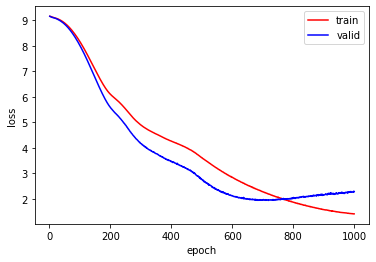

<Figure size 432x288 with 0 Axes>

In [39]:
x = np.arange(1, train_results.shape[0]+1)
plt.plot(x, train_results[:, 0], label='train', color='red')
plt.plot(x, valid_results[:, 0], label='valid', color='blue')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.savefig(opt.output_dir+'/loss.png')

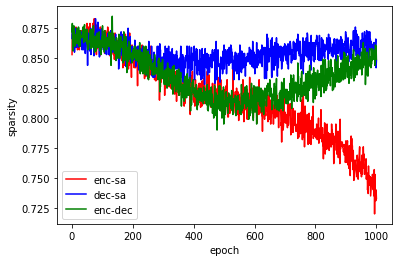

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(x, sparsity_results[:, 0], label='enc-sa', color='red')
plt.plot(x, sparsity_results[:, 1], label='dec-sa', color='blue')
plt.plot(x, sparsity_results[:, 2], label='enc-dec', color='green')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('sparsity')
plt.show()
plt.savefig(opt.output_dir+'/sparsity.png')